<a href="https://colab.research.google.com/github/ElizavetaNosova/HSE_ML_homework/blob/master/SentimentClassificationHW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
В качестве домашнего задания мы предлагаем вам решить задачу бинарной классификации на большом корпусе imdb рецензий на фильмы. 
Корпус можно скачать по ссылке http://ai.stanford.edu/~amaas/data/sentiment/

Ваша задача в sklearn, используя три разных алгоритма, построить и обучить классификаторы, для каждого из них посчитать метрики качества. Постройте ROC кривую и посчитайте величину ROC AUC. Выберите лучший классификатор.

Используя предсказания вероятностей класса, найдите 15 самых негативных и самых позитивных рецензий по мнению модели.  - 7 баллов

Написать свои функции, которые бы считали tp, fp, tn, fn, и возвращали точность, полноту и ф-меру и применить их к результатам, полученным вашими классификаторами (если все сделано правильно, то результаты должны совпадать с полученными  sklearn метриками). - 3 балла

Файлы csv получены с помощью следующего кода (не в колабе)

In [0]:
import os
import pandas as pd


class pd_reviews:
    def __init__(self):
        self.df = pd.DataFrame({'Text': [], 'Polarity': []})
    
    def add_review(self, text, polarity):
        self.df.loc[len(self.df)+1] = [text, polarity]
    

class review_organizer:
    def __init__(self, train_pos_dir, train_neg_dir, test_pos_dir, test_neg_dir):
        self.train = self.make_review_df(train_pos_dir, train_neg_dir)
        self.test = self.make_review_df(test_pos_dir, test_neg_dir)
    
    
    def make_review_df(self, pos_dir, neg_dir):
        reviews = pd_reviews()
        for file in os.listdir(pos_dir):
            try:
                file_name = pos_dir + '\\' + file
                with open(file_name, 'r', encoding='utf-8') as f:
                    text = f.read()
                reviews.add_review(text, 'pos')
            except Exception as e:
                print(e)
        for file in os.listdir(neg_dir):
            try:
                file_name = neg_dir + '\\' + file
                with open(file_name, 'r', encoding='utf-8') as f:
                    text = f.read()
                reviews.add_review(text, 'neg')
            except Exception as e:
                print(e)
        return reviews
            
    def save_csv(self):
        try:
            os.mkdir('Reviews')
        except OSError:
            pass
        os.chdir('Reviews')
        self.train.df.to_csv('train.csv')
        self.test.df.to_csv('test.csv')
        
os.chdir('D:\\ML_HSE\\review_data')
train_pos_dir = 'train\\train_pos'
train_neg_dir = 'train\\train_neg'
test_pos_dir = 'test\\pos'
test_neg_dir = 'test\\neg'

reviews = review_organizer(train_pos_dir, train_neg_dir, test_pos_dir, test_neg_dir)
reviews.save_csv()

Напишем функцию для оценки моделей бинарной классификации, прежде чем строить их

In [0]:
class metrics_counter():
  def __init__(self, predicted, correct, checked_type):
      self.checked_type = checked_type
      self.counter =  {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}
      self.presition = 0
      self.recall = 0
      self.f2 = 0
      self.count(predicted, correct)
      self.update_metrics()

  def add_sample(self, res):
     if res[0] == self.checked_type:
        if res[1] == self.checked_type:
             self.counter['tp'] += 1
        else:
              self.counter['fp'] += 1
     else:
          if res[1] == self.checked_type: 
              self.counter['fn'] += 1
          else:
              self.counter['tn'] += 1     

  def count(self, predicted, correct):
      for i in range(len(predicted)):
        res = [predicted[i], correct[i]]
        self.add_sample(res)

  def update_metrics(self, f2const = 2):
      try:
          self.presition = self.counter['tp']/(self.counter['tp'] +self.counter['fp'])
      except ZeroDivisionError:
          self.presition = 0
      try:
          self.recall = self.counter['tp']/(self.counter['tp'] +self.counter['fn'])
      except ZeroDivisionError:
          self.recall = 0   
      try:
        self.f2 = f2const*self.presition*self.recall/(self.presition + self.recall)
      except ZeroDivisionError:
        self.f2 = 0


class review_classification_metrics:
    def __init__(self, predicted, correct):
        self.pos = metrics_counter(predicted, correct, 'pos')
        self.neg = metrics_counter(predicted, correct, 'neg')
        self.macropresition = (self.pos.presition + self.neg.presition)/2
        self.macrorecall = (self.pos.recall + self.neg.recall)/2

    def print_report(self):
      print('Качество работы с положительными отзывами: presition=', self.pos.presition, 'recall=', self.pos.recall, 'f2=', self.pos.f2)
      print('Качество работы с отрицательными отзывами: presition=', self.neg.presition, 'recall=', self.neg.recall, 'f2=', self.neg.f2)
      print('Общее качество работы: mactopresition=', self.macropresition, 'macrorecall=', self.macrorecall)


def print_metrics(predicted, correct):
  metrics = review_classification_metrics(predicted, correct)
  metrics.print_report()




In [1]:
from google.colab import files

uploaded = files.upload()

Saving train.csv to train.csv


In [2]:
uploaded = files.upload()

Saving test.csv to test.csv


In [0]:
import pandas as pd

In [0]:
train_data = pd.read_csv('train.csv')

In [0]:
train_data.head(5)

,Unnamed: 0,Text,Polarity
0,1,Bromwell High is a cartoon comedy. It ran at t...,pos
1,2,Homelessness (or Houselessness as George Carli...,pos
2,3,Brilliant over-acting by Lesley Ann Warren. Be...,pos
3,4,This is easily the most underrated film inn th...,pos
4,5,This is not the typical Mel Brooks film. It wa...,pos


In [0]:
test_data = pd.read_csv('test.csv')

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_data.Text)

Метод K ближайших соседей

In [0]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier().fit(X_train_counts, train_data.Polarity)

In [0]:
X_test_counts = count_vect.transform(test_data.Text)

In [0]:
y_predicted_proba_neighbours = clf.predict_proba(X_test_counts)

In [0]:
y_test_correct = test_data.Polarity

In [0]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot

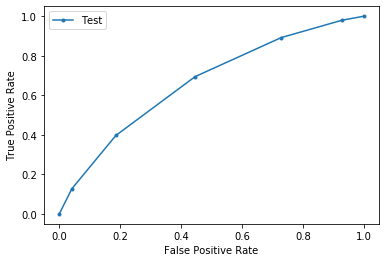

In [0]:
y_true = np.array([i == 'pos' for i in list(y_test_correct)])
y_predicted = xlf_y_predicted_proba_neighbours[:,1]
fpr, tpr, _ = roc_curve(y_true, y_predicted)
pyplot.plot(fpr, tpr, marker='.', label='Test')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [0]:
print(roc_auc_score(y_true, y_predicted))

0.664382144


In [0]:
y_predicted = list(clf.predict(X_test_counts))

In [0]:
print_metrics(y_predicted, y_test_correct)

Качество работы с положительными отзывами: presition= 0.6088053841839596 recall= 0.69472 f2= 0.6489314003885817
Качество работы с отрицательными отзывами: presition= 0.6445603576751118 recall= 0.5536 f2= 0.5956274746083663
Общее качество работы: mactopresition= 0.6266828709295357 macrorecall= 0.62416


Наивный Байес

In [0]:
from sklearn.naive_bayes import MultinomialNB

In [0]:
clf = MultinomialNB().fit(X_train_counts, train_data.Polarity)

In [0]:
predicted_proba_baies = clf.predict_proba(X_test_counts)

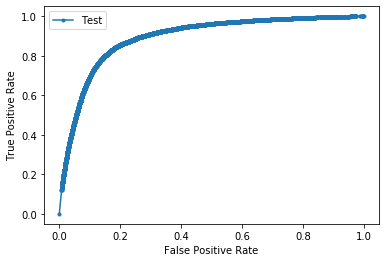

In [0]:
y_true = np.array([i == 'pos' for i in list(y_test_correct)])
y_predicted = predicted_proba_baies[:,1]
fpr, tpr, _ = roc_curve(y_true, y_predicted)
pyplot.plot(fpr, tpr, marker='.', label='Test')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [0]:
print(roc_auc_score(y_true, y_predicted))

0.8918530528


In [0]:
y_predicted = list(clf.predict(X_test_counts))

In [0]:
print_metrics(y_predicted, y_test_correct)

Качество работы с положительными отзывами: presition= 0.8605464078741606 recall= 0.7484 f2= 0.8005648025330537
Качество работы с отрицательными отзывами: presition= 0.7774081675985561 recall= 0.87872 f2= 0.8249652634346013
Общее качество работы: mactopresition= 0.8189772877363584 macrorecall= 0.81356


Метод максимальной энтропии

In [0]:
from sklearn.linear_model import LogisticRegression

In [8]:
clf = LogisticRegression().fit(X_train_counts, train_data.Polarity)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
predicted_proba = clf.predict_proba(X_test_counts)

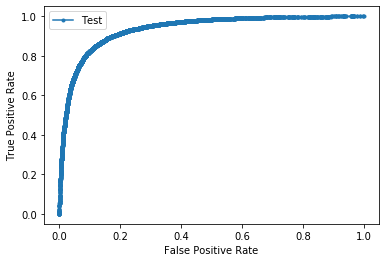

In [0]:
y_true = np.array([i == 'pos' for i in list(y_test_correct)])
y_predicted = predicted_proba[:,1]
fpr, tpr, _ = roc_curve(y_true, y_predicted)
pyplot.plot(fpr, tpr, marker='.', label='Test')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [0]:
print(roc_auc_score(y_true, y_predicted))

0.9352467008


In [0]:
y_predicted = list(clf.predict(X_test_counts))




In [0]:
print_metrics(y_predicted, y_test_correct)

Качество работы с положительными отзывами: presition= 0.8707394452127227 recall= 0.85632 f2= 0.863469527689267
Качество работы с отрицательными отзывами: presition= 0.858660580782246 recall= 0.87288 f2= 0.8657119054230967
Общее качество работы: mactopresition= 0.8647000129974844 macrorecall= 0.8646


Метод ближайших соседей работает для решения задачи классификации тональности на основе CountVectorizer не сильно лучше случайного угадывания; из проверенных лучше всего работает модель Logistic Regression.
Найдём по 15 самых негативных и 15 самых позитивных отзывов, используя вероятности, которые предлагает эта модель.
Эти отзывы действительно воспринимаются как положительные и отрицательные соответственно

In [0]:
test_data_copy = test_data

In [0]:
test_data_copy.Polarity = clf.predict_proba(count_vect.transform(test_data_copy.Text))

In [0]:
test_data_copy = test_data_copy.sort_values(by=['Polarity'])

In [0]:
most_positive = list(test_data_copy.Text[:15])
for i in range(len(most_positive)):
  print(i)
  print(most_positive[i])

Самые положительные отзывы:
0
This is a great German slasher, that's often quite suspenseful, and creative, with a fun story and solid performances. All the characters are cool, and Benno Fürmann is great as the psycho killer, plus Franka Potente gives a fantastic performance as the main lead. It did take a little while to get going, but it was never boring, and it had some good death scenes as well, plus the music is wonderfully creepy. I was lucky enough to get the subtitled version, instead of the dubbed, and I thought all the characters were quite likable, plus it's very well made and written as well. It has some really good plot twists too, and the effects are extremely well done, plus the ending is great. The finale is especially suspenseful, and Franka Potente was the perfect casting choice in my opinion, plus I wish Arndt Schwering-Sohnrey(David) didn't get killed of so soon, because he was a really cool character. There were actually a couple of moments where I felt uncomfortable but in a good way, and I must say this film deserved all it's praise, plus while it does have plot holes, it's not enough to hamper the film. This is a great German slasher, that's often quite suspenseful, and creative, with a fun story, and solid performances, I highly recommend this one!. The Direction is great!. Stefan Ruzowitzky does a great! Job here with excellent camera work, very good angles, great close ups (see the opening sex scene), doing a great job of adding creepy atmosphere, and just keeping the film at a very fast pace.<br /><br />There is quite a bit of blood and gore. We get cadavers cut open,plenty of very gory surgery scenes,lots of bloody stabbings,people are dissected while still being conscious, severed finger, self mutilation, gutting's, bloody slit throat, lots of wicked looking frozen corpses, plenty of blood and more.<br /><br />The Acting is very solid!. Franka Potente is fantastic as the main lead, she was very likable, remained cool under pressure, was vulnerable, easy on the eyes, and we are able to care for her character, the only time she seemed to suffer, was when she had to spurt out some bad dialog here and there, but that wasn't very often, she was wonderful!. Benno Fürmann is excellent as the psycho killer, he was simply chilling, and wonderfully OTT, he really gave me the creeps, and was one effective killer!. Anna Loos played her role very well, as the smart slut, I dug her. Sebastian Blomberg was great here as Caspar, he was quite likable, and had a mysterious character,his chemistry with Potente was also on, and there was a great twists involving him at the end. Holger Speckhahn was good as the Idiot Phil and did his job well. Traugott Buhre is good as Prof. Grombek. Arndt Schwering-Sohnrey was great as David, he had a really cool character, and I wish he didn't get killed of so soon. Rest of the cast do fine.<br /><br />Overall I highly recommend this great German slasher!. ***1/2 out of 5
1
The Hand of Death aka Countdown in Kung Fu (1976) is a vastly underrated early work by director John Woo. The film stars Dorian Tan (Tan Tao-liang) and features Jackie Chan, Sammo Hung and James Tien in significant supporting roles. Many people believe, or have been lead to believe by deceptive advertising, that this is a Jackie Chan film. This is not a Jackie Chan film, Dorian Tan is the star but Jackie gives one of his best (most serious) early performances.<br /><br />The Hand of Death is about a Shaolin disciple named Yunfei (Tan) who is sent on a mission to assassinate a Shaolin traitor named Shih Xiaofeng (Tien) and protect a revolutionary named Zhang Yi (Woo). Along his journey Yunfei meets up with a young woodcutter named Tan (Chan) and a disgraced sword fighter (Chang Chung) known as "the wanderer." Both men have suffered at the hands of Shih and want to take revenge. The three team up to defeat Shih and his eight bodyguards and escort the revolutionary to safety.<br /><br />The martial arts action is above average under the direction of Sammo Hung. Dorian Tan uses his trademark high kicks very effectively as the "Northern eighteen styles kicks" along with some "Southern five styles boxing." Sammo Hung and Jackie Chan provide excellent martial arts performances as well. James Tien is not the greatest martial artist on the Jade screen but does an acceptable job. Some of the early fights are a bit slow and seem over choreographed but the final showdowns featuring Chan, Tan and Hung are very good.<br /><br />Director John Woo provides plenty of interesting character development in the film, which is refreshing. The cinematography by Leung Wing Kat is very stylish, unique and beautiful for a kung fu film of this era. Joseph Koo's music: a combination of soft flutes and 70's "Shaft" style orchestral pieces is kung fu cinema at its best. Hand of Death is not Jackie and Sammo's usual kung fu comedy. Hand of Death is a serious, straightforward revenge driven story.<br /><br />Hand of Death aka Countdown in Kung Fu is an underrated classic in the old school kung fu genre. The film is one of the best artistically of its time and a preview of the great things to come from Jackie Chan and Sammo Hung. Hung's great choreography is put on display here before his directorial debut and Chan's early charisma and talent can be clearly seen.<br /><br />Hand of Death is a solid, stylish old school kung fu film and a brilliant early work of the legendary John Woo.<br /><br />Kung Fu Genre Rating 7.5/10 <br /><br />Wanderer to Tan (referring to his new weapon): "The Little Eagle Wing God Lance." <br /><br />Tan: "Just a knickknack."
2
1904. The North African nation of Morocco is hanging onto a tenuous Independence, as the various European powers - France, Germany, Britain, Russia, Spain, and now the United States - are vying for influence in the region. The Sultan (Marc Zuber) is a weak puppet; his uncle, the Bashaw (Vladek Sheybal), who is being manipulated by the French and Germans, is the real power behind the throne. Enter Berber Chieftan Raisuli (Sean Connery), the leader of the Rif tribe and "the last of the Barbary Pirates", who kidnaps an American missionary, Eden Pedecaris (Candice Bergen) and her two children and takes them hostage. Back in the US, President Theodore Roosevelt (Brian Keith) threatens to go to war over the issue: "Pedecaris Alive or Raisuli Dead!" - seeing the issue as the perfect way to exercise his "Big Stick" diplomacy, though Secretary of State John Hay (John Huston) is not so confident. However, the Raisuli has less sinister plans for the Pedecarises, who are more than capable of handling themselves in any event.<br /><br />John Milius's great historical film, based VERY loosely off of a true story (i.e. Pedecaris was a middle-aged man), is a wonderful bit of escapism. It has some amazing action scenes, a witty, well-written script, a fine cast enjoying themselves with the material, and does not overstay its welcome like, say, "Pirates of the Caribbean" or the "Lord of the Rings" movies. It's not really an "epic" film in the strictest sense, but it's one of the best pure action movies ever made.<br /><br />While the historical context is shaky, the storyline is interesting, and as some reviewers point out, it is even more pertinent today than it was when made. As President Roosevelt says, "America is like a grizzly bear" - fierce, strong, but a little blind and reckless at times. At the time of the film's setting, America has just been propelled onto the world stage as superpower, following their resounding victory in the Spanish-American War - and Roosevelt seizes this incident as a way to prove America's worth. In real life, it didn't quite work out that way, but allegorically it works well. While written from a right-wing perspective, Milius's screenplay is pretty accurate in assessing America and its place in the world. He admires Roosevelt and his method of "big stick" diplomacy, and correctly recognizes (in the words of Roosevelt) that while America may be feared and respected, they'll never be truly "loved" by the world, no matter what they do. And there are some scenes - like Roosevelt's target shooting of European leaders and the almost-comic surprise attack by Marines on the Bashaw's palace - which show America's reckless and violent side, while others - the climactic showdown with the Germans - show their heroism.<br /><br />The historical/political context of the film is, of course, merely meat on the bones of what is essentially a rousing action/adventure film. There are some brilliantly done action scenes, such as Raisuli's rescue of the Pedecaris's from double-crossing tribesmen, which features some of the best swordplay in any film. The opening entrance of the Raisuli and the aforementioned march and attack of the US Marines are brilliantly done bravura set pieces. And the final battle, which combines elements of "Lawrence of Arabia" and "The Wild Bunch", while a major historical fantasy (a three-way battle between Germans, Americans, and the Rifs), is a superbly staged, adrenaline-pumping sequence.<br /><br />The excellent cast gives some wonderful performances. Everyone seems to be having a fun time with the film, and it shows. Sean Connery is surprisingly convincing as a Berber with a Scottish accent, but manages to pull off his interesting, well-drawn and chivalrous character who comes to respect his hostage and abhors modern, uncivil warfare. Candice Bergen, an actress whom I've never been fond of, gives a fine performance as the feisty Eden Pedecaris, who is every bit as tough as her captor. Brian Keith is an amazingly convincing TR - you really feel he must have been like this, an athletic, blustering, yet practical and intelligent man with an admirable sense of self. The scenes of Roosevelt boxing and target-shooting while discussing foreign policy are some of the greatest "bad ass" moments in movie history - and who can forget lines like "Why spoil the beauty of the thing with legality?" John Huston provides solid support as the weary, cautious Hay, acting as a perfect foil to the much more impetuous Roosevelt. <br /><br />Among the fine supporting cast, the best are Geoffrey Lewis as Samuel Gummere, the cynical Ambassador caught in the middle of the political intrigue, and Steve Kanaly, as the gung-ho Marine Captain who cheerfully advocates (and carries out) "Military intervention!" as the blunt and simple solution to the whole complex situation. Other familiar faces such as Vladek Sheybal, Nadim Sawalha, Roy Jenson, Larry Cross, Marc Zuber, and Darrell Fetty also do fine work, no matter how small their role. Spaghetti Western fans will recognize Antoine Saint-John ("A Fistful of Dynamite") as the German general and Aldo Sambrell as one of Raisuli's tribesmen.<br /><br />"The Wind and the Lion" is, all around, a wonderfully done adventure film. It has something for everyone: wonderful gun- and swordplay, a lot of humor, a tough, feisty heroine (and her two cute children), a nice (if unconsummated) romance, and an interesting (if fanciful) political/historical context. It's not a masterpiece, but hey, it wasn't trying to be. I give "The Wind and the Lion" a stirring nine stars and my highest recommendation.
3
Tony Hawk's Pro Skater 2x, isn't much different at all from the previous games (excluding Tony Hawk 3). The only thing new that is featured in Tony Hawk's Pro Skater 2x, is the new selection of levels, and tweaked out graphics. Tony Hawk's Pro Skater 2x offers a new career mode, and that is the 2x career. The 2x career is basically Tony Hawk 1 career, because there is only about five challenges per level. If you missed Tony Hawk 1 and 2, I suggest that you buy Tony Hawk's Pro Skater 2x, but if you have played the first two games, you should still try this one. Overall, there really isn't anything new, but it is still very fun to go through the game. Hopefully this review benefits your needs.<br /><br />Graphics: 7 out of 10 Overall, the clean visuals isn't really one of Tony Hawk's Pro Skater 2x's main characteristics. The atmosphere has been changed around a lot from Tony Hawk 1 and 2, and the character models look a little bit improved. When you look back to Tony Hawk's Pro Skater 1 and 2 on the old PS1, the thought that those old graphics are ugly run through your head. In Tony Hawk's Pro Skater 2x, the graphics are rendered A LOT better. The character models are no longer filled with jaggys, the textures are more smooth, but not to the farthest extent. Tony Hawk's Pro Skater 2x's visuals do not compare to Tony Hawk 3's graphics, but Activision probably didn't want to make Tony Hawk's Pro Skater 2x have extraordinary graphics. Overall, the graphics deserve an average score of 7 because they did not put the full power of the Xbox to use in here. Graphics are nice, and clean, that's all I have to say.<br /><br />Sound: 8 out of 10 The sound effects don't deliver much to the imagination, but the skateboards popping off of the ground sound great. The main reason why I gave the sound factor a rating, was because you are not obligated to listen to the below average Tony Hawk soundtrack, because there is a custom soundtrack feature. The sound effects sound a lot better than the sounds in Tony Hawk 1 and 2, mainly because it is more clearer, and just the fact that everything sounds great. One of the main reasons why I bought this game, is because of the custom soundtrack. The grind sound effects still sound the same as the first two games did, just a little tweaked out. One of the major problems of the sound factor, is the fact that if the song is over, it will NOT proceed to the next track, the song that you have just listened to will just play over again. I don't like the in-game soundtrack, but like I said, you are not obligated to listen to it.<br /><br />Controls: 10 out of 10 The controls are the best part of Tony Hawk's Pro Skater 2x. The control set-up is marvelously comfortable, and easy to get used to. Back in the Playstation days, people thought that the controls were the best ever, but it looks like 2x has done a better job with the Xbox control. Surprisingly, it is very easy to use the control stick to execute tricks. Activision has done great work with Tony Hawk's Pro Skater 2x's controls. They have made the Xbox controller the best for Tony Hawk games. You will not be disappointed with the control style, and that is a guarantee.<br /><br />Game play: 10 out of 10 Excluding the fact that Tony Hawk's Pro Skater 2x is basically Tony Hawk 1 and 2 put together, the game play is still unbelievably fun. The game play factor has been changed around a bit. This time, you get A LOT more air than in the first two games, and it is a lot easier to perform tricks. In Tony Hawk's Pro Skater 2x, each character has three career modes, consisting of Tony Hawk 1 career, Tony Hawk 2 career, and the 2x career. Tony Hawk 1 career is rather easy because in the first game, you get NOTHING for air. The Tony Hawk 2 career delivers the same amount of difficulty as the playstation version did. The only amount of difficulty that applies to the 2x career, is finding out where all items are, but after you've done that, 2x career is no hard at all. In the 2x career, there is a total of 3 levels, and the first two levels consist of finding the secret tapes, collecting S-K-A-T-E, and doing whatever else is required for that particular level. The third level out of the three, is the competition level, where you have to get a certain amount of points to get the gold. In the first two levels, the secret tapes, and collecting the letters S-K-A-T-E, are featured in both of them. Overall, Tony Hawk's Pro Skater 2x still maintains the old Tony Hawk's Pro Skater vibe.<br /><br />Story: -<br /><br />Fun factor: 10 out of 10 Tony Hawk's Pro Skater 2x is by far, the most funnest game on Xbox today. I have played Tony Hawk's Pro Skater 1 and 2, and back then, I didn't like them, but for some reason, Tony Hawk's Pro Skater 2x is really fun. There really isn't much to say, except that Tony Hawk's Pro Skater 2x is by far, the best game on Xbox today. One problem, is that if you've already gone through the game once, you will play it a couple more times, but it will be repetitive.<br /><br />Replay value: 10 out of 10 Tony Hawk's Pro Skater 2x delivers a high amount of replay value. There is a lot of cheats to unlock, and a lot of character videos. Overall, Tony Hawk's Pro Skater 2x has lots of replay value, mainly because it is so fun.<br /><br />Best feature: You are not obligated to listen to the crappy in-game soundtrack. Worst feature: The custom soundtrack is a bit messed up.<br /><br />Final Statement: Lots of people have complained in the past that they didn't like Tony Hawk's Pro Skater 2x because there is nothing new, but they should stop complaining because your getting a lot of game for $50.00.<br /><br />Graphics: 7 out of 10. Sound: 8 out of 10. Control: 10 out of 10. Game play: 10 out of 10. Story: N/A Fun factor: 10 out of 10.<br /><br />Overall score: 9 out of 10.
4
The Hand of Death aka Countdown in Kung Fu (1976) is a vastly underrated early work by director John Woo. The film stars Dorian Tan (Tan Tao-liang) and features Jackie Chan, Sammo Hung and James Tien in significant supporting roles. Many people believe, or have been lead to believe by deceptive advertising, that this is a Jackie Chan film. This is not a Jackie Chan film, Dorian Tan is the star but Jackie gives one of his best (most serious) early performances.<br /><br />The Hand of Death is about a Shaolin disciple named Yunfei (Tan) who is sent on a mission to assassinate a Shaolin traitor named Shih Xiaofeng (Tien) and protect a revolutionary named Zhang Yi (Woo). Along his journey Yunfei meets up with a young woodcutter named Tan (Chan) and a disgraced sword fighter (Chang Chung) known as "the wanderer." Both men have suffered at the hands of Shih and want to take revenge. The three team up to defeat Shih and his eight bodyguards and escort the revolutionary to safety.<br /><br />The martial arts action is above average under the direction of Sammo Hung. Dorian Tan uses his trademark high kicks very effectively as the "Northern eighteen styles kicks" along with some "Southern five styles boxing." Sammo Hung and Jackie Chan provide excellent martial arts performances as well. James Tien is not the greatest martial artist on the Jade screen but does an acceptable job. Some of the early fights are a bit slow and seem over choreographed but the final showdowns featuring Chan, Tan and Hung are very good.<br /><br />Director John Woo provides plenty of interesting character development in the film, which is refreshing. The cinematography by Leung Wing Kat is very stylish, unique and beautiful for a kung fu film of this era. Joseph Koo's music: a combination of soft flutes and 70's "Shaft" style orchestral pieces is kung fu cinema at its best. Hand of Death is not Jackie and Sammo's usual kung fu comedy. Hand of Death is a serious, straightforward revenge driven story.<br /><br />Hand of Death aka Countdown in Kung Fu is an underrated classic in the old school kung fu genre. The film is one of the best artistically of its time and a preview of the great things to come from Jackie Chan and Sammo Hung. Hung's great choreography is put on display here before his directorial debut and Chan's early charisma and talent can be clearly seen.<br /><br />Hand of Death is a solid, stylish old school kung fu film and a brilliant early work of the legendary John Woo.<br /><br />Kung Fu Genre Rating 7.5/10 <br /><br />Wanderer to Tan (referring to his new weapon): "The Little Eagle Wing God Lance." <br /><br />Tan: "Just a knickknack."
5
Universal Studios version of "Flipper" (1996) is a great heartwarming film for the entire family with good values and sentimentality. It is the story of Sandy Ricks, a teenager from Chicago who reluctantly spends his vacation with his Uncle Porter Ricks in the Bahamas. This ultimately changes the teenagers life and he grows up in the process. He learns to appreciate nature and to have a respect for the environment. I grew up in the 1960's and the NBC television show "Flipper" was my favorite childhood show. Elijah Wood is perfectly cast as a 1990's Sandy Ricks and gives an excellent performance. As much as I liked the NBC television show and MGM theatrical feature films with Luke Halpin as Sandy in the 1960's I liked this feature the best! I feel Elijah Wood is the best Sandy Ricks. With respect to Luke Halpin I feel Elijah Wood has more of a range of acting talent and emotes more as an actor which makes his performance excellent and more believable. I think Elijah Wood is the best young actor working today in films. Director Alan Shapiro also wrote the screenplay and has done an excellent job as both writer and director of this film. Paul Hogan gives a comical and likable performance as Sandy's Uncle Porter Ricks. Mr. Hogan's performance perfectly offsets Elijah's role as Sandy. I am a big fan of underwater films. This film was beautifully shot in the Bahamas like "Thunderball" (1965 UA) was. The director of photography was Bill Butler A.S.C. who lensed the film "Jaws" in 1975. Mr. Butler is a very talented cinematographer. The underwater director of photography was Pete Romano. He did a superb job with the underwater cinematography. I enjoyed the film score by Joel McNeely. This good film score featured Crosby, Stills and Nash among other talented artists. This motion picture was shot in Panavision like "Thunderball" in the aspect ratio of 2.35:1 If possible try to see this film in a scope version as originally framed and visioned by Alan Shapiro and Bill Butler. Another very nice thing is that Mr. Shapiro gave the "original" Sandy Ricks (Luke Halpin) a small part in this remake. He portrayed Bounty Fisherman #3 in this film. This was a very kind gesture on Mr. Shapiro's part! As you can tell I am a real true fan of this film. Sadly this beautiful film was met with harsh words by the majority of movie critics. I originally saw this movie on my birthday, May 31st of 1996 in a movie theater. It meant a lot to me. I have it on numerous video versions. The VHS versions are in "pan and scan". The laserdisc version is "letterboxed" 2.35:1! I even have a VCD in 2.35:1 from Hong Kong which is "letterboxed". But my most prized possession is an "original" 16mm theatrical feature print which I will treasure for the rest of my life! Thank you Mr. Shapiro, Elijah Wood, Paul Hogan and everyone involved for making this a memorable movie for me to enjoy!<br /><br />P.S. I must add that the quality of the Universal DVD is superb! It is the best DVD as far as quality I have ever seen. The color and resolution is spectacular. The soundtrack is great. I think Universal must have used the same transfer for the DVD that they did for the laserdisc version. The 35mm scope print is "mint" and Alan's film really has a wonderful look to it. A great tribute to a wonderful film! The DVD's resolution is even superior to the laserdisc quality! It's just spectacular! Thank you Universal Home Video for the great quality control and transfer. Many thank's for doing a superb job on this wonderful family film. Also many thank's to you Alan for all your extreme kindness to me!!! It's a real honor to know you!!! (Review Revised/Updated June 27, 2005)
6
OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full
7
Director Mikhail Kalatozov's film The Cranes are Flying (Letyat zhuravli) is a glorious piece of cinema. From the screenplay by Viktor Rozov, based on his own play, Kalatozov shows us a vision of the heroism of war and the suffering by those left at home. Inundated with countless war movies showing us the frontlines and the carnage, the topic itself becomes tedious and avoidable. However, this Russian gem shows how the tale of hardship can be told in a different way; by telling us, straight from a soldier's mouth how war is hated by all, that they hope those who died did so for a cause that will allow for peace and the end of fighting, we see a new vision of WWII. We have young men volunteering to wage war for peace, to keep their families and loved ones safe at home rather than draftees fighting a battle they don't believe in. With so much hatred towards our current situation in the Middle East, and how people are dying for no reason, against their will, it's nice to see a film that shows just how selfless and heroic these soldiers are, as well as those awaiting their return.<br /><br />Communist Russia shows how involved all were in the war. While Boris may have volunteered to go to the frontlines, his father is head doctor of a hospital aiding in the mending of soldiers injured and his sister is helping him there as well as his girl Veronika, doing all she can to keep her mind off the fact that no letter has arrived from her love. An entire city comes out to send the boys off in celebration. Even the factory that Boris and his friend Stepan work for send representatives over with gifts of gratitude. Whether this is all a glorified look into Russia at the outset of WWII or not, I don't know. There are no protests or badmouthing of these boys risking their lives for a country, it is all praise and thanks. Some in America could learn a lesson from this because whether you agree with the war at hand or not, protesting and wreaking havoc in its name only sullies what these men and women are sacrificing each and everyday.<br /><br />The acting is top-notch throughout, but some deserve singling out. I really enjoyed Antonina Bogdanova in a small role as Boris' grandmother. She is the one family member he can trust and her sadness at his leaving is very evident on her face and through her body language. Vasili Merkuryev, as the patriarch Fyodor Ivanovich, brings what is perhaps the best performance. As spoken at the end, about fathers needing to choke back hidden tears, Merkuryev epitomizes those sentiments. He puts on a tough exterior, especially cracking jokes and riding his son hard when he finds out about his volunteering just hours before he must leave. But when Boris exits to go to the assembly station we see the true pain of the man, seated in sorrow at the table. He loves his son dearly and although he may not be able to show it to him, his actions throughout the film express it to the audience. Aleksey Batalov is effective as Boris, a happy-go-lucky young man, and idealist, doing what he believes is right, and Aleksandr Shvorin is good as the villainous Mark, staying home due to his talented piano skills, or maybe just to steal his cousin's love. That love, played by Tatyana Samojlova, really draws the audience in to her grief, dejection, and slim glimmer of hope. The true star of the film, she must go through many emotions on a journey where she does lose her way, needing to steer back on course, hoping that she did so soon enough for Boris' return.<br /><br />Besides the realism to the story, as well as being unafraid to use tragedy to get the theme across, I also loved the visual style of the film. Sergei Urusevsky's cinematography is amazing, especially when considering the movie was shot in fullscreen. It is one thing to create stunning compositions in a widescreen panorama; it is completely different to do so in a square frame. Right from the beginning we get a beautiful static shot of a winding walkway along water, a bridge in the background at the top, as our two lovers skip their way up the screen and into the distance. There are multiple instances of the camera being behind barriers yet still allowing for the action to be seen, creating unique spatial depth and interest at all times. Sharp angles are utilized, as well as careful blocking to allow for overhead shots and exaggerated juxtapositions of characters in frame together.<br /><br />The real feats, however, are those instances of the long shot. Used well towards the end to follow Veronika through the mass of returning soldiers, it is magnificent earlier on as she roams through those saying goodbye to their loved ones while she searches for Boris, her own farewell needing to be said. The planning for this shot must have been extensive because while she weaves in and out of people, the camera focuses on couples kisses, people yelling to one another, and more, all purposely in frame at specific moments while the camera moves through. Everyone needed to hit his mark precisely and it leads to a brilliant piece of cinema. It's just one part of an overall masterpiece of tone and style; The Cranes are Flying shows how successful placement and mise en scène can be in showing the audience what it needs in as simple a way as possible. Composition and professionalism from the actors and crew can work wonders, adding something that huge setpieces and special effects can never do.
8
Life is comprised of infinite possibilities; some known, others a mystery and destined to remain so. And what of the vast unknown, the realms beyond which knowledge has no established boundaries or parameters? Who is to say what exists or what is possible? Valid questions, all of which are raised and explored in the story of a particular individual's personal journey, a strange and dramatic odyssey that defies facts and logic, in `K-PAX,' directed by Iain Softley, and starring Kevin Spacey and Jeff Bridges. In the wake of an incident in New York's Central Station, a man named Prot (Spacey) is transported to a psychiatric hospital in Manhattan, where he is delivered into the care of Dr. Mark Powell (Bridges), who attempts to uncover the truth about his patient, who claims to be from the distant planet K-PAX. It quickly becomes a challenge for Dr. Powell, as Prot, with his calm, direct, forthcoming manner and a propensity for produce (he eats bananas peels and all, and Red Delicious Apples are his favorites) is quite convincing. But it's Powell's job, as well as his nature, to be skeptical. Prot's claims, however, remain intact and stand up even under the most intense probing and the watchful eye of Dr. Powell, who finds himself in something of a quandary-- Prot even tells him the exact date and time that he will depart for K-PAX, a scheduled return trip that allows Powell but a short time to sort it all out. And Powell just can't seem to get his mind around the idea that he is dealing with a real alien being; and it's something he is going to have to resolve quickly, if he is ever going to know the truth. And he has to know. The truth, after all, is the only thing that is going to set him free in his own mind.<br /><br />	Softley has created and delivered a sensitive, thought-provoking film that challenges the viewer by sustaining the mystery surrounding Prot while forcing you to reflect upon your own concepts of what is, in fact, possible. And as you never know for sure about Prot until the denouement, you are able to identify with Powell, seeing the situation from his point of view and trying to solve the riddle right along with him. Softley creates an atmosphere of wonder and a real sense of being confronted with something that is truly unique as the story unfolds and you begin to realize that Prot just may be what he says he is. And in the context of the reality to which the film is disposed, it's an engrossing matter to try to wrap your mind around. How do you react when all of the evidence is contrary to the physical limitations we've set for ourselves? While at the heart of the film there is a resounding depth of humanity that is evident, not only in Prot, but in Dr. Powell, as well. All of which makes for an extremely engaging and gripping drama.<br /><br />	As we've come to expect, Kevin Spacey gives a brilliant performance as Prot, presenting his character from the inside out, emotionally deep and physically convincing at the same time. This is a unique individual, and Spacey brings him to life with care and the ability to share those moments that are particularly revealing, which adds to the believability of the character and the credibility of the story itself. For this film to work, it is essential that we believe who and what Prot is; we do, and it does. Spacey simply pulls it off magnificently. It's a memorable performance, from which evolves a character that will stay with you for a long, long time.<br /><br />	Jeff Bridges, meanwhile, emerges on equal footing with Spacey, adeptly making a very real person of Dr. Powell. It's a fairly straightforward role, and the challenge for Bridges was to take this very normal and ordinary character and make him unique in his own right, which, opposite the character of Prot was no small task. And, again, for this film to work it was necessary for Bridges to rise to the occasion. And, with exceptional skill and being the consummate professional that he is, he succeeds without question. Bridges infuses Powell with an underlying complexity, and is so giving in his performance, that it makes the interaction between Powell and Prot vibrant, and at times intense. It's a demonstration of two of the finest actors in the business doing what they do best, creating a dynamic that is alive and inspiring. It's a great job by Bridges, who never attempts to steal the spotlight from Prot, which serves to raise the level of the film to an even higher notch.<br /><br />	The supporting cast includes Mary McCormack (Rachel), Alfre Woodard (Dr. Villers), Ajay Naidu (Dr. Naidiu), Vincent Laresca (Navarro), Kimberly Scott (Joyce), Conchata Ferrell (Betty) and Saul Williams (Ernie). An entertaining, emotionally involving film, `K-PAX' is a dissertation on possibilities, as well as an examination of the ever evolving complexities of the human condition. It's a film that demands an open mind and rewards those who are able to approach it on it's own terms and embrace it. In the end, it makes you realize just how real K-PAX is; and it makes you appreciate Prot's journey, and just how much we all share and have in common with those around us, human or alien. And it may just make you reflect upon your own journey-- where you've been and where you're going. And that's the magic of the movies. I rate this one 10/10. <br /><br />
9
Anthony Minghella's 'The English Patient' is a film that takes us back to the golden years of Hollywood. It is grand and impressive in scale, and yet so heartbreakingly intimate in its portrayal of human love and suffering. At the 1997 Academy Awards, the film owned the night, taking home nine awards from twelve nominations, the most decisive cleansweep since Bernardo Bertolucci's 'The Last Emperor' in 1988. Based on Canadian author Michael Ondaatje's 1992 Booker Prize-winning novel of the same name, 'The English Patient' is a touching meditation on life, love and loss, tracing the history of a critically-burnt man in the aftermath of World War Two.<br /><br />During the war, a man (Ralph Fiennes) is discovered in the burning remnants of a crashed plane. With his face scarred beyond recognition, and with the man seemingly suffering from amnesia, he is assumed to be an Allied soldier, and is simply referred to as "the English patient." After the war, in the mine-ridden hills of Italy, a kind nurse, Hana (Juliette Binoche), who has apparently lost everybody close to her, remains in a ruined monastery to look after the dying man. Over time, she comes to learn more and more about her "English patient," who is actually revealed to be a Hungarian geographer, Count Laszlo de Almásy. Rather than losing his memory in the plane crash, we learn that this scar-ridden man has perhaps chosen to forget his past, both to protect himself from persecution and to cure himself of the tragic memories of his past love. Via numerous flashbacks, we learn of Almásy's former exploits in the Sahara desert, and his romantic liaison with a married woman, Katharine Clifton (Kristin Scott Thomas).<br /><br />It's certainly easy to see why 'The English Patient' was so successful at the Oscars. It is such a beautiful film, blending the quiet beauty of the Italian countryside with the endless golden sands of the desert. Cinematographer John Seale captures the landscape to perfection; not since David Lean's magnificent 'Lawrence of Arabia' has a film shown the desert with such beauty and grandeur, making particularly good use of sweeping aerial shots from Almásy's plane. Even in the film's more intimate moments, excellent use of close-ups and lighting capture the emotion of the scene, coupled, of course, with the brilliant performances from all the cast members.<br /><br />A long-time favourite actor of mine, 'The English Patient' might just contain Ralph Fiennes' finest performance, and, considering his history includes such films as 'Schindler's List' and 'The Constant Gardener,' this is not a complement that is to be taken lightly. His Count Laszlo de Almásy is initially a very sympathetic character, but, as we slowly learn more about his past, his likable qualities are eroded by his less-admirable tendencies towards others. "Ownership" is a major theme of the film. When asked by Katherine what he hates most, Almásy replies with "Ownership. Being owned. When you leave you should forget me." However, as the relationship progresses, and Katherine perhaps tries to distance herself from him, Almásy reveals a hint of arrogance, insisting that his love for her somehow entitles him to have her whenever he likes: "I want to touch you. I want the things which are mine, which belong to me."<br /><br />Juliette Binoche, who received an Oscar for her performance here, is excellent as Hana, the lonesome nurse who fears to love because of the tragedies that have always harmed those close to her. After some time of caring for Almásy alone, she is joined by a dubious Canadian thief, David Caravaggio (Willem Dafoe), who lost his thumbs during the war, and who suspects that it was Almásy who betrayed him to the Germans. Hana also strikes up a tentative romantic relationship with Kip (Naveen Andrews), an Indian bomb-diffuser in the British Army. However, due to her past history, Hana is afraid that becoming involved with Kip will doom him to death, particularly considering his very dangerous line of work.<br /><br />At 160 minutes in length, 'The English Patient' wonderfully evokes memories of the classic romantic epics of old, successfully finding a balance of mystery, love, joy and tragedy. The ending of the film is heartbreaking and sorrowful, but also uplifting in its own way. Whilst some romantic relationships are doomed from the very beginning, others have a very good chance of bringing happiness. Nevertheless, in every case, it is always better to have loved and lost, than never to have loved at all.
10
Looking back at the career of Alfred Hitchcock, it never fails to be surprising how such a brilliant and visionary man could be denied sufficient recognition for how revolutionary he was for the film industry. It is likely a sign of how ahead of his time Hitchcock was, always attempting to push the envelope, and never coasting along with a film made simply for the purpose of being entertaining, but always with a deeper, more poignant motive on his mind. Strangers on a Train, one of Hitchcock's first and more underrated hits, is a perfect example of these traits - an entertaining and suspenseful story, even when viewed over 50 years later, yes, but so carefully and intelligently constructed it stands today as a masterpiece in film technique. <br /><br />Arguably one of the pioneering "suspense thrillers", Strangers on a Train may come across as slightly dated in certain aspects, but it retains every bit of superbly crafted tension as it did back in 1951 (if perhaps slightly less shocking). The brilliant use of cinematography and lighting as well as quick, careful editing are what really make the film stand out, drawing out every possible iota of tension and retaining the audience's focus even in slower scenes. If there was ever any doubt of what a simply masterful filmmaker Hitchcock was, simply watching five minutes of Strangers on a Train should be enough to disavow such sentiments; every shot is so carefully chosen and constructed, all serving to drive the storyline ahead in a particularly innovative fashion. Sadly enough, there are certain moments in the story which are screechingly out of place enough to jar our focus away from the superb cinematography and editing - Bruno being able to reach down to the bottom of a sewer grate is simply unbelievable, and the figure of a stereotypical old man crawling under a wildly out of control carousel provides unintentional comedic relief in what is meant to be the film's most tense and engaging scene. These are only brief moments, but they are enough to stand out as painfully weak in an otherwise stellar film.<br /><br />But what really makes Strangers on a Train stand out is the story premise. As Hollywood films of late run the risk of descending inescapably further and further into the vat of turgid clichée after clichée, it's wonderfully refreshing to see a 50 year old film with a premise which actually comes across as smart and original. Sure it's fairly straightforward, but the concept of "swapping murders" is simply one that would not fly in films of today's day and age, which makes it all the more entertaining to watch; the film's brilliant screenplay keeps the action flowing at a swift pace while providing us with some wonderfully memorable lines all the while. One can't help but notice the deeper themes Hitchcock is alluding to throughout as well, especially the concept of "darkness in humanity's heart", demonstrated by elderly ladies being fascinated and exhilarated by the prospect of murder, as well as Bruno's own cavalier attitude towards death. Hitch also works in many moments of dark humour (Bruno popping a child's balloon with his cigarette is priceless), and irony, shooting suspenseful scenes in happy, easy-going environments, such as the iconic carnival scenes, to create an even more eerie atmosphere. This may be a suspense thriller, yes, but to overlook the brain concealed beneath it would be simply inexcusable. <br /><br />The antagonistic figure of Bruno (essayed to perverse perfection by Robert Walker, sadly in his last film role, but easily stealing the film from his admittably very talented fellow cast members) is without a doubt what makes Strangers on a Train so memorable, as the character is a marvel to behold. Here we have a simply superbly crafted villainous figure, all the more intriguing by how ordinary and unassuming he seems. Rather than cackling madly and thwarting the hero at every possible moment, Bruno is a calm, controlled, psychotic mess. He speaks of murder in such an offhand tone, yet retains a passionate glint in his eye when discussing different fashions of killing people. Bruno could seem to represent the "Id", as Freud would put it, the inner, darker and uninhibited aspects of mankind. It makes an interesting contrast to the hero figure, Guy Haines, and how bland and uninteresting he seems, almost as if to drive home the prospect of evil being much more interesting and appealing than constantly striving to do the right thing. <br /><br />Yet despite this implied message, Hitch still twists our emotions enough that we root for Guy at every turn, and cheer at each new obstacle he is forced to overcome. It's a testament to actor Farley Granger's talent that despite Robert Walker's villain easily stealing the show, Granger's hero still comes across as sympathetic, still commanding our support even when falling prey to being a far less compelling character. Superb support is given by Ruth Roman, who manages to overcome the clichée and be a more innovative and complex romantic interest figure, Kasey Rogers giving a stunning performance as Guy's horrifyingly manipulative and hedonistic first wife, and Patricia Hitchcock, proving that she is far more talented than being simply "the director's daughter" would imply. The superb cast (headed by a simply wonderful Walker) really bring the film to life, adding so much more merit to the film than simply Hitchcock's breathtaking stylistics. <br /><br />All in all, Strangers on a Train may still come across as slightly too dated for certain viewers, but it's still a shock how modern and appealing to contemporary audiences seems, considering it was released half a century ago. Once again, Hitchcock proves his unparalleled mastery of tension and film technique, and the film's surprisingly original and enjoyable premise is alone worth a viewing. Highly recommended to anyone wishing to undertake a brilliantly made but superbly entertaining film experience! <br /><br />-9/10
11
Wallace and Gromit are the main characters in some of the best cartoons ever crafted. The excellent mix of visual humor and claymation makes "A Grand Day Out," "The Wrong Trousers," and also "A Close Shave" some of the best animated footage ever put on television. Winning several Oscars and also countless other awards, Nick Park became quite the popular man in the U.K., yet his impact on the United States has not been big. After the third Wallace and Gromit short, there was all this speculation about a full-length Wallace and Gromit movie, yet for years nothing had happened. Then in 2000 instead of a full-length Wallace and Gromit film, we get another brilliant claymation film from Nick Park, which was Chicken Run, which almost got nominated for best picture in the Academy Awards. Perhaps it was the success of this film that ultimately drove Park to finally work on a Wallace and Gromit project.<br /><br />5 years later (these kinds of films do take long you know) and a lot of anticipation, Wallace and Gromit finally hits the big screen. Despite the rather weak trailers and marketing campaign, this movie delivers in so many ways. This film will be a delight for both kids and parents. With tons of adult humor hidden beneath the brilliant animation, Wallace and Gromit: Curse of the Were-Rabbit is one of the few films that perfectly manages to equally appeal to both kids and adults. This rather difficult technique is one that only Pixar has already perfected and DreamWorks has had a lot of trouble doing lately. Despite the DreamWorks logo slapped onto the poster, this film is mainly from the very creative staff of Aardman Animations.<br /><br />Wallace and Gromit are first seen running a business that protects the townspeople's crops from being ruined by rabbits, which apparently had been running around wild and in great numbers lately. Their business has gotten them plenty of respect from the others living in the town because a gigantic vegetable contest was rapidly approaching and the crops needed protection. Complications arise when Wallace attempts to manipulate the rabbits into not liking vegetables and then a great eating machine is unleashed on the area. It is up to Wallace and Gromit to find the gigantic animal and stop it from eating away through gardens and also their approval from the townspeople. To add to that, Wallace wants to impress Lady Tottington, which also captured the attention of a snobby suitor by the name of Victor. Simple plot yes, but there is more than meets the eye, be prepared for a few fun surprises along the way, kind of like in the other Wallace and Gromit cartoons.<br /><br />In animated films with little dialogue, it is the animation that has to set the pacing and the mood of the film. Despite requiring 5 years to produce only 85 minutes of footage, the payoff is fantastic. There is a massive amount of detail that requires more than one viewing to truly notice. Even more incredible than the detailed and nearly flawless animation is the truly unspeakable amount of visual humor put into the film. Whether it is a creatively placed shot or normal labels put into the funniest position possible, or it is the oh-so-adorable rabbits that is constantly shown in the film, most Curse of the Were-Rabbit's humor comes strictly from just watching the movie itself and catching all the references before it is too late. Just picture the movie Madagascar, except funnier much fewer pop culture references, and better animation.<br /><br />Casting was great, even though in a film with not much dialogue, it was not that important. Peter Sallis yet again does a wonderful job as Wallace, even though in this movie there was no stand-out quote that can be used anytime (The Wrong Trousers: "It's the wrong trousers Gromit, and they've gone wrong!"). Ralph Fiennes does a superb job as the lead villain Victor and also Helena Bonham Carter (known as the crazy female lead in the cult hit "Fight Club") lends her lovely voice as she plays Wallace's love interest. Even though nothing could top the final chase in "The Wrong Trousers," Curse of the Ware-Rabbit did have plenty of action scenes, including one fantastically done chase scene between Gromit and Victor's evil dog. Last but not least, the rabbits really steal the show at some moments. Whether it is their cute expressions, their funny movements, or their howling, the rabbits in the film even take some of the glory from the main stars. The funniest rabbit in the movie is the "cursed" rabbit himself, to the very end of the movie he had the audience rolling in laughter.<br /><br />Bottom Line: Despite not being as memorable as "The Wrong Trousers", this film is just as good and entertaining as Chicken Run. Unlike almost every movie to come out this year, the movie does not drag at all, clocking in at a short 85 minutes yet containing so much joy and fun, it will leave everyone watching it asking for more. There is very little wrong with the film; it was a pure delight to watch. This film is a total contrast of the decent yet vulgar, uncut, raw movies that have made a surprising amount of money earlier this year (40-Year-Old Virgin, Wedding Crashers, and Sin City) and for families and those who want harmless entertainment; that is a good thing. Highly recommend, this is the top animated movie to come out this year and among the best we have seen this decade. Wallace and Gromit: Curse of the Were-Rabbit: totally harmless fun from second 1 to second 5,100.
12
I have never been a great fan of Oliver Stone, often because I have found his films to be forced, preachy and generally flawed. The two Stone films I truly like are JFK and Talk Radio, yet Talk Radio takes the cake for being Stone's finest achievement. Stone is a director whereby you are either a fan or you are not, it is safe to say that before watching Talk Radio I was not fond of the guy and considered one of the most overrated directors in the film industry, though after watching Talk Radio some of my perceptions have changed. Talk Radio is an unsettling and amusing attack on what is now known as "reality TV".<br /><br />Talk Radio follows a self-indulgent, dysfunctional, determined, hysterical, outrageous and perplexing radio host, named Barry Champlain who hosts a controversial late-night radio show in Dallas. Quickly becoming well known for his bold and quirky air-presence he becomes a late night sensation, whereby depraved junkies, delinquents, racists, sociopaths, sickos, perverts and morons call in to be ridiculed on air. The film shows the rise and fall of the man's career, carefully making an accurate portrayal on freedom of speech. Originally adapted from a stage-play, the film attaches itself to the theatre theme that it was originally built around, wonderfully conveying the film's fierce nature.<br /><br />With the ferocious energy and non-stereotypical air, Talk Radio brings all the hilarity behind "crass media". It remains even more poignant today than it was in the late '80s. The film goes into depth studying the likes of arrogance, self-obsession, offensive behaviour, controversy, hypocrisy and ignorance. The film shows through a controlled manner how it is good to have a personal opinion and freedom of speech, yet it is something that should be used wisely rather than shamefully blunt. Stone tries to show how freedom of speech is a crucial importance in life, but is something that we should be wary and cautious about. The film asks the question of "is our main protagonist just the same as the sad people who call up the show?" <br /><br />Stone fabulously creates the film's key set-piece (the radio station) with an ambition and cold atmosphere. He then succeeds in capturing the isolation, fear, ambiguity and the dangerous emotions that are built up at the radio station. Eric Bogosian is perfectly cast as the isolated, self-absorbed and complex genius, Barry Champlain. He fits the role perfectly letting off his lines with such enthusiasm, urgency, perplexity, brusqueness and ultimately the bold hilarity of his offensive nature. The performance brims with spark, which was evidently robbed of an Oscar nomination. His voice suits the character, being that a primary element of a radio host and his power of acting along with tragedy and comedy works brilliantly.<br /><br />There is a strong use of editing in Stone's films and Talk Radio boasts some of his cleanest, most rhythmic editing. He uses beautifully controlled camera techniques, which differ from being calm to suddenly becoming turbulent. There is a vibrant energy behind the film, with its raw and wonderfully delightful script working as a centre-piece for the greatness of the film. The striking and virtuous cinematography stands out in the moments inside and outside the studio, most impressively capturing the city at night. Not forgetting the hauntingly heartbreaking and yet darkly funny climatic "spiral to decline" is ultimately remarkable cinema.<br /><br />Talk Radio is an essential modern masterpiece, I am certain you will be surprised by just how great it really is. I highly recommend Talk Radio for anyone interested in media or film. Talk Radio is a fine example of top-notch, intellectual and insightful entertainment, which still packs a well-earned wakeup call. Finally, if it was not for Eric Bogosian the film would not be the fun, delightful and enduring masterpiece it is today.
13
1983 was "the battle of the Bonds". That year both Roger Moore and Sean Connery starred in two separate James Bond film, the former (Octopussy) was produced by the "official" makers of the Bond films while the later (Never Say Never Again) was produced "unofficially" by a group led by Kevin McClory who held the film rights to Thunderball. Surprisingly enough is the "unofficial" film that is better despite the obvious flaw of and the fact that Never Say Never Again is a remake of Thunderball.<br /><br />Never Say Never Again has the distinction of sporting one of the best casts ever assembled for a Bond film. It all starts with Sean Connery, returning to the play Bond for the first time since 1971's Diamonds Are Forever. Connery might be older then he was then but he looks better here then he did in Diamonds Are Forever. The Bond of Never Say Never Again is the sleek and dangerous shark of Dr. No or From Russia With Love, just a few years older. Connery's delivery of one liners and dialogue is as dead on as it ever was. The one downside to Connery's age is his believability, especially when it comes to the ladies of the film. Let's face it even Connery, despite being in top physical shape, looks as odd as Moore when he is bedding women half his age. Yet despite this believability issue, Never Say Never Again shows Connery in one of his better Bond performances and a definite improvement on his two earlier Bond performances.<br /><br />Kim Bassinger plays Domino in one of her early film roles. Bassinger plays the role with considerable confidence for a relative newcomer and she makes the character believable. Bassinger holds her own against her co-stars and has considerable chemistry with them as well. In fact she may well outshine her Thunderball counter-part played by Claudine Auger.<br /><br />Then there's the villain, Maximilian Largo played by Klaus Maria Brandauer. Brandauer's Largo is everything a James Bond film villain should be: suave, charming, evil and above all believable none the less. Brandauer makes the role realistic and chooses not to fall into the trap many other Bond villains have fallen into by going over the top. Brandauer plays Largo with a silent menace and charisma unseen in many adversaries of 007.<br /><br />The excellent cast extends into the supporting cast as well. Barbara Carrera makes a fine henchwoman in Fatima Blush and the screen lights up when she appears. Max Von Sydow a nice appearance as Blofeld, though his appearance is more akin to a cameo. Rowan Atkinson makes an appearance as Bond's bumbling contact that makes for some of the best scenes in the film. With all that the highlight of the supporting cast comes from the MI6 staff from Edward Fox's M who makes for a great contrast to Bernard Lee, Pamela Salem who make s affine Moneypenny and the icing on the cake with Alec McCowen's wonderful Q. The supporting cast has a couple of misfires though in the form of Bernie Casey as Felix Leiter and Gavin O'Herlihy as Jack Petachi who both seem to lack credibility in their respective roles. Otherwise this film sports one of the best casts ever assembled for a Bond film.<br /><br />On top of an excellent cast the film has several other essential ingredients. From the opening Central America sequence to the fight at Shrublands to the underwater sequences and motorbike chase, this is a film where the action sequences are not only great but service the plot as well for the most part. The film also sports good special effects in terms of cruise missile models, explosions, and all the things we expect from a Bond film. Irvin Kershner, then fresh off doing The Empire Strikes Back, brings a tight sense of direction to the film especially in sequences like the substation of nuclear warheads and the subsequent theft of the cruise missiles.<br /><br />Yet this film is far from perfect. Never Say Never Again is easily one of the most dated of the Bond films with its heavy use of 1980's computer sand video games. While technology dates any film after a time, this film's heavy reliance on it, especially in the hijacking of the cruise missiles and the Domination sequence makes the film look incredibly dated some quarter of a century after its release. The script also tends to suffer from predictability due to the very fact it's a remake of Thunderball.<br /><br />Yet for its predictability the script for Never Say Never Again is pretty good. The script sports good dialogue scenes, not a single cringe worthy one liner (how many of the Roger Moore era scripts can you say that about?), some humorous situations, and yet is watchable and tense for the most part. Once you look past he fact that it's a remake, there's quite a lot of good things in the script for the film.<br /><br />Music is in fact the biggest weakness of the film. Due to the "unofficial" status of the film, the James Bond Theme could not be used. That said this could have shown with the right composer that a Bond score without it could work. Unfortunately Michael Legrand's score is far from adequate. Legrand's score is totally out of place in a Bond film and there is only of or two places where it actually works. To make matters worse the film is also lumbered with one of the worst title sequences ever to grace a James Bond film.<br /><br />Despite being heavily dated, somewhat predicable, and having a bad score Never Say Never Again is still a good Bond film. With one of the best casts of any Bond film, good action sequences, good special effects, good direction, and some terrific dialogue, this film proves that "unofficial" isn't a bad thing. In fact it is is better then Octopussy and the winner of "the battle of the Bonds".
14
This is a surprisingly great low budget Horror/Comedy, it's funny and pretty well made, with good performances and a really cool twist ending!. All the characters are pretty cool, and the story while unoriginal is very good, plus Eric Jungmann(Adam) and Justin Urich(Harley) had fantastic chemistry together. One of the funniest moments in the film for me is when Adam is trapped in the bathroom, and Harley wakes up to find that monster truck sitting there, and decides to take a p*ss in the truck, and Aimee Brooks is just plain sexy!, plus this is one of the best low budget Horror films I have seen in a long time. It's very gory, but in a comical way, and I thought it was very well written as well, plus Michael Bailey Smith is fantastic as the Monster Man and had some wicked makeup!. It's similar to films like Joy Ride, Duel, Jeepers Creepers, etc, etc and it has some suspenseful moments here and there, plus The gore effects are really well done for the most part. This is a surprisingly great low budget Horror/Comedy, it's funny and pretty well made, with good performances and a really cool twist ending, I highly recommend this one!. The Direction is very good!. Michael Davis does a very good! job here, with great camera work, good angles,good use of colors, and using a great setting, plus he kept the film funny and at a very fast pace.<br /><br />There is a lot of gore!. We get extremely bloody nose bleeds,gory impaling's, bloody stabbings,guy is cut in half by a monster truck, human remains in a cooked stew, guts all over the place,guys guts fall out,pencil in the eyes,bloody slit throat,bunch of people walking around without limbs,gory dead squirrel,heads are squished,severed limbs,bloody and mangled corpses,decent amount of bloodshed,one very gory scene at the very end and more!.<br /><br />The Acting is very good for a low budget film. Eric Jungmann is fantastic here as Adam, he was a nerd but a very likable one, he had fantastic chemistry with Justin Urich, had some cool lines,and I just loved his character, he also seemed to be enjoying himself,and he was especially good at the end!. Justin Urich is excellent as the ass of a Best Friend, however I just couldn't help but love him as he was very funny, and often stole a lot of the scenes, I really dug him!. Aimee Brooks is gorgeous, and did great with what she had to do, she had good chemistry with Jungmann and like Jungmann was especially good at the end, as I loved her mysterious character. Michael Bailey Smith is wonderful as The Monster Man he was very creepy looking, had some awesome makeup, and is now one of my favorite slashers!. Rest of the cast do fine.<br /><br />Overall I highly recommend this one!. ***1/2 out of 5

In [0]:
most_neg = list(test_data_copy.Text[-15:])
for i in range(len(most_neg)):
  print(i)
  print(most_neg[i])

Самые отрицательные отзывы:
0
For the first time in reviewing films, I found myself immediately uninterested in this story. I don't know if it was the way that it was filmed or the story behind the characters, but it felt bland, overused, and completely unoriginal. Within the first thirty minutes, I found myself rather apathetic with all the characters and the story. I felt as if I had seen this structure before, and Tart was providing nothing new to surprise me. After thinking that it may just be my mood, I stopped the film and chose to start it fresh in the morning, but the same feeling persisted. I just didn't care. That is not a good sign. The characters were bland. When I say bland, I literally mean that by watching them develop, you will never have any flavor hit your palate. The story seemed recycled, nearly to the point of plagiarism. Now, I am not saying that Christina Wayne stole this story, but she added nothing fresh to the perspective. The casting was horrid, the underlying symbolism and themes were so far lost that no critic could find them (nor the characters), and the stories were vague and sloppy. You knew nothing about anyone or anything, and instead of pushing more emphasis on the characters, we instead found ourselves with drugs, minor sex, and money pushed into our faces. These are themes we have seen in every film since the dawn of film time, yet somehow could not be creatively captured by Wayne.<br /><br />What immediately pulled me away from this story? It was mainly the characters. I have seen most of Brad Renfro's work, and honestly he needs to redefine himself. Director Larry Clark has defined him, and oddly he cannot get out of that stereotypical character. Within the first twenty minutes of Renfro's screen time I was bored. I knew exactly what he was trying to portray and why. It was spectacular nor impressive, just repetitive. He needed to bring some excitement or suspense to his role, instead of just blandly playing this random socialite. Without a strong character, the final climax of this film comes instead as a letdown. Renfro did not showcase the best of his abilities in this film. While I am on the subject  nobody showcased the best of their abilities. What is going on with Dominique Swain, outside of Lolita, I don't believe she has really emerged as an actress, and following-up with roles such as Cat Storm doesn't help. Bijou Phillips was the only actress that I witnessed actually try to bring something remarkable to the screen, sadly due to everyone else's horrid acting, she was lost. Rambling here and there, and honestly nearly forgotten about during the second act. Melanie Griffith was a pointless cast and most of this film's budget probably went to her TWO scenes that she was in. Maybe the rest of it went to the random guy from The Kids in the Hall, who desperately needs to place himself far away from this project.<br /><br />My biggest problem, outside of the acting, was the pacing of this film. Nothing, and this is hard for me to say, but nothing gelled together. There were so many sub-stories happening throughout the course of the film that no actual substance was formed. The robberies, the teenage "angst and woe", the wealthy socialites learning how horrible real life is, the random Kids in the Hall guy, and even the ending just felt rushed and horribly edited together. With this shoddy craftsmanship the whole story never really formed any true shape. Family structures were never defined, characters were never given any emotion, and all we are left with are bits and pieces of honest leftovers. Wayne did not complete the task at hand.<br /><br />While I hate to put the entire burden on the director, with this film I am left with little choice. With a horrid title that just screamed the complete opposite of what this film was about, with amateurish directional ability the cast pretty much was able to give every emotion in every scenes, leaving us with disgusting acting and poor developments, and with vague storytelling it is hard to place any "good" behind Tart. This was a film I had heard nothing about, and after viewing it I can see why. All Wayne has done with this film is random take excerpts from other films that have done a better job of defining all the elements above and cut all together to make the film Tart. It is hard for me to say this, but Wayne ruined this film. While I don't believe there was much to fully take from the story, any remaining elements of excitement were drained as Wayne took the helm. While most of the time you can credit some of the story, perhaps strong acting, or even the music, in Tart you can credit nothing. From the opening sequence until the end, I felt like I was swimming through very lumpy oatmeal. No consistency, no strength.<br /><br />Overall, this film is a waste of your time. If you are searching for some deep symbolic elements or possibly some banter on our society, you will not find it in this film. While I know that was what Wayne was attempting to show, the final product seems like it was edited on an Etch-a-Sketch. It was an embarrassing film to sit through, and encourage nobody to pick it up. Wayne threw to the wind all the teachings of her Columbia University education and destroyed two hours of my life. Avoid at all costs! <br /><br />Grade: * out of *****
1
If you loved the early-60's version of "The Time Machine", don't waste your time; as with last year's "The Planet of the Apes", this has been "reimagined", and not for the better. And, just as with "Planet...", its lead actor is woefully miscast and leaden; Guy Pearce, a terrific actor of great range, is all wrong for this role, giving a one-note performance that elicits zero sympathy; he's so dour and serious, and lacking in awe of the (supposedly) amazing things he sees that you don't believe for a moment that he's experiencing them. Worse yet, whose idea was it for him to resemble the love child of David Spade and Calista Flockhart?? A handsome actor, here he is sickeningly gaunt, which is, believe it or not, a major distraction. Frankly, the man looks gravely ill and is photographed cruelly. He shares absolutely NO chemistry with anyone on the screen, a direct result of a performance that is out of sync with anyone else's. Sadly, even with a proper leading man this movie doesn't stand a chance for it is fatally burdened with both a totally inept director - whole scenes go nowhere and are poorly realized - and a screenplay that is utterly inferior, scattered and at times incoherent - not for a single moment do you care about anyone in this film, for the single fact that there is NOTHING in the way of character development! In the original, you got to KNOW the Eloi, so therefore you felt for them, and felt their terror of the Morelocks; here, as the movie stresses several times, they are nothing but sheep and act accordingly. Unless you're a member of PETA, scared sheep are HARDLY the stuff of entertainment! <br /><br />Samantha Mumba does as well as possible, in her movie debut, but, like everyone else in this mess, most especially Jeremy Irons (if he's the leader of the Morelocks [who look like rejects from "The Mummy Returns"], why then does HE look like Edgar Winter's long-lost brother?) is COMPLETELY WASTED. Also wasted was the money spent on the endless 'special' effects, which belie the $70M spent on the film; they are uniformly lackluster, obvious and unconvincing. And then there's the look of the film: poorly photographed, its art direction and sets are just "there" and its costumes are typical in design. There isn't an original thought or idea expressed behind or on the screen. Most of all, it isn't even fun! (The filmmakers use the now-ubiquitous Orlando Jones as "comic relief" but, as usual, Jones is irritating, and just HOW does his electrically-driven character survive in a world seemingly devoid of electricity?)<br /><br />All in all, this is an empty, lifeless, dull, sterile and confused affair: didn't they ALREADY REMAKE "Planet of the Apes"??? (At least THAT had the fortune of some strong performances!) <br /><br />*SPOILER!* The final insult (beyond a head-shakingly terrible, not to mention convenient, ending)? Not only do they BARELY feature the changing dress-store figures, they make even the time machine itself an anachronistic, gaudy glass-n-chrome bore! (If "The Sopranos" had a time machine, THIS is exactly what it would look like.) Pathetic...
2
There really are no redeeming factors about this show. To put it simply, its just terrible. Absolutely dreadful. It's just a dreadful "reality" show. Not only that, it's dreadful fiction.<br /><br />Imagine this: A bunch of overly-imaginative teenagers get together one night and go "Hey! Let's make a paranormal show just like "Ghost Hunters" and whatnot!" So they grab a camera, harass local residents and film random landscapes behind a painfully "trying-to-be-dramatic-yet-failing-misreably" monologue. This show is basically a bunch of teenagers running around with a home movie camera trying to make a really bad horror documentary. The only difference is this show actually has a budget and writers. A wasted budget and terrible writers.<br /><br />Oh, the problems, how do I count thee? Well, first off, let's talk about this from a personal level. I am not a total skeptic when it comes to the paranormal. I am willing to believe in whats paranormal and whats not, and I'm sure there are a lot of people who feel the same. So, if you're going to do a show about the paranormal, you have to do a good job convincing the viewer that what they're seeing is either paranormal or not, because the viewer can easily believe otherwise. I hate to compare, but I don't see why not at this point. Take "Ghost Hunters" for example. In "Ghost Hunters" you can tell that the cast is leveled with the audience. They're not totally skeptical, yet they're still willing to keep the possibility of any paranormal anomalies in mind. They have to look at something and be willing to say "this is possible that its simply nothing". And, with that in mind, they set out to try and prove themselves wrong. They use technology and several other gadgets along with constant moderation to determine what is paranormal along with bearing the fact that what they may be monitoring could be nothing in mind. Not only are they trying to convince themselves what is real and what is not, in the process they are trying to convince you. That element of doubt is not present in "Paranormal State". Strike one.<br /><br />In "Paranormal State", the cast simply says "there's this spooky place, and its HAUNTED, so we're going to find some SPIRITS!" And immediately you know and saying to yourself "Okay, convince me otherwise". The cast is not professional in their interviews. In fact, sometimes it seems like they're just harassing local residents of these so-called "haunted" areas. They have no real evidence to back up their claims besides assumptions and theories, and the best they can must up is somebody who "claims" they can contact the dead, with no one ever backing up who this person is and how valid they really are. They could have easily just picked some random person off the street and said "pretend you can contact spirits for our show" and went at it. In the "Mothman" episode, this just happens. Without any convincing evidence towards the end of the show, they bring this sort of individual out where he does a random, painfully scripted "reading" of a supposed area of how something is "haunted" in order to convince its audience. Very, very poor effort. I feel that one of the main problems with the show is that it feels scripted. During one of the episodes, the cast gets attacked by one of these "paranormal anomalies" at times in an attempt to be dramatic. These sort of dramatic sequences would make any skeptic laugh and even those who are on the fence realize what they're watching is just a bunch of tabloid-esquire trash. If the show's aim was to try and convince their audience that these "paranormal" events are real, they're doing a horrifically poor job at doing so. Strike two.<br /><br />However, there is always the counter. Just one last viewpoint to see if the show is actually worth something. What if the show isn't trying to convince you that these paranormal events are real and are simply trying to entertain you with good fiction? It even fails on that level as well. If the show's creators were trying to craft fiction to entertain its audience, the writing is too poor and even on a fictional level, it fails to convince the audience that its cast members are really experiencing the unknown in all its full, horrifying glory. The writing is simply not compelling and even, dare I say, boring. Strike three.<br /><br />So what remains of this show is simply a bunch of teenagers who are too willing or too gullible to believe in the paranormal simply because its simply much more amazing than reality who set out with a camera, a bad script and bad actors to generally just make a really bad horror documentary. Thats all the show is at this point. There is no reason to see it, not even for the entertainment factor, and there's no reason to care about it. To be blunt, its lame. There are absolutely no redeeming factors about this show.
3
The Bone Collector is set in New York City & starts as one of the world's foremost criminologist's & crime scene experts Lincoln Rhyme (Denzel Washington) is involved in an accident which leaves him a bedridden quadriplegic. Jump forward four years & Alan (Gary Swanson) & his wife Lindsay Rubin (Olivia Birkelund) are kidnapped, soon after New York cop Amelia Donaghy (Angelina Jolie) is called to a crime scene & finds the buried & mutilated body of Alan. Amelia notices some unusual crime scene evidence & makes a note of it which impresses Rhyme when he is asked to work on the case, he quickly realises the evidence are in fact cryptic clues to the whereabouts of Lindsay. Having cracked the clues the cops get there too late to save her but this is just the beginning as a sadistic serial killer continues to kill & leave forensic clues for Rhyme & the police...<br /><br />Directed by Phillip Noyce I watched The Bone Collector last night & I have to say it's one of the worst big budget post The Silence of the Lambs (1991) & Se7en (1995) serial killer thrillers I have seen, in fact it makes Friday the 13th (1980) look sophisticated & realistic! The script by Jeremy Iacone was based on the book by Jeffery Deaver & is so poor on so many levels I hardly know where to begin. For a start it takes itself deadly seriously & that makes all the other flaws seem twice as bad. The character's are truly awful & I didn't believe any of them were actual human beings. First we have Lincoln Rhyme who is paralysed from the neck down & there's just not a lot the script can do with him, in fact he quite literally can't do anything but lie in bed for the whole film. He is seemingly impressed with Amelia because she stopped a train & thought a fresh footprint near a murdered person might be of relevance, I'm not being funny here but wouldn't any cop realise a footprint near a murder victim might be of some relevance? Why is he so impressed with her? Then there's Capatin Cheney who is not only unlikable & shouts at everyone for no apparent reason but is so incompetent that he failed to connect several murders committed in a short space of time where each victim had sections of flesh & skin surgically removed from their bodies, how exactly did this guy get to be a police Captain? Then there's the killer whose motives are less than plausible, are you trying to tell me they devised an intricate plan to murder at least seven people because they spent six years in jail for something they actually did? If they wanted revenge on Rhyme why did they kill all those other people who had no connection to anything, I could maybe just about buy someone wanting revenge against the guy who put them away but not to kill several other people who have no connection to themselves, the intended target Rhyme anything else. Also after devising an intricate plan to kill these people & get away with it they suddenly turn into the most stupid person in history as despite holding a large knife & being able to walk & use their arms they are actually defeated & nearly killed by a quadriplegic who has no movement in his body below his neck! How did that happen? I should also mention Amelia who is a terrible character, she actually buys her own camera to take crime scene photo's & shoots rats for no apparent reason.<br /><br />Besides some of the worst written character's ever the story & plot isn't much better We never find out why the killer is using The Bone Collector book as inspiration We never find out why the killer was taking strips of flesh from his victims. It's never explained why a rookie cop like Amelia is allowed to enter crime scenes even before the proper forensic teams. There is no reason given for why the killer chooses his victims. Also the killers clues are a little obscure aren't they? I mean a bloody animal bone & shaved rat hair? Logically how does someone go from a bone & rat hair to the exact pinpoint location of the next victim & has the whole of New York to choose from? There's some nonsense about a bird that sits on Rhymes window ledge which is just totally random & at almost two hours The Bone Collector is really slow going. There is so much wrong with The Bone Collector & it all comes down to one of the worst scripts ever, it's atrocious on all levels & has zero credibility. Apparently Angelina Jolie has stated that she shot nude scenes for this film but they were cut because they were felt to be too distracting.<br /><br />With a supposed budget of about $48,000,000 The Bone Collector is well made with good production values & that Hollywood gloss about it. I also must add right now that I think Angelina Jolie gives one of the worst performances I have ever seen, I think she is absolutely terrible in this. Denzel Washington just sort of lies there really, Queen Latifah is awful & even Michael Rooker can't do much as he is stuck with a clichéd & one dimensional character.<br /><br />The Bone Collector has to be one of the worst Hollywood films I have seen in a while, I saw it for free on telly last night & I still feel cheated & ripped-off. There are just so many things to poke holes at it's silly, embarrassingly awful or should that be awfully embarrassing? Works either way to be honest...
4
By the mid 1990s, the career of animator-director Don Bluth had seemed to drop to its all-time low. Before, Bluth had made a series of popular animated films, many which remain beloved today such as "The Land Before Time" (1988), "The Secret of NIMH" (1982), and "An American Tail" (1986). But beginning with "Thumbelina" in 1994, his films seemed to decrease more and more in quality and popularity and one of the many unfortunate entries is 1995's box office bomb "The Pebble and the Penguin", a film that didn't attract audience members beyond parents and children under the age of seven. Frankly, the latter are the only audience members I can comprehend taking enjoyment out of this rather bland animated feature.<br /><br />The story is absurd. The film stars a poorly-drawn, stammering, and chubby penguin named Hubie (voiced by Martin Short) who falls in love with a female penguin with a surprisingly healthy flower on her head (voice by Annie Golden). SORT OF like in real life, penguins present their bride-to-bes with a pebble as a substitute for a ring. But when Hubie is swept away by the current, he teams up with a lone rockhopper (James Belushi) with a dream of flying and they race against time to return to Antarctica before it's too late. The reasons why they could be too late is one of many underdeveloped elements of this weak story that would still be weak even if they were there.<br /><br />It becomes very clear very early on why this animated children's musical does not and will not work for anybody older than say six or seven years of age. It just does not have any of the qualities that are required for a good animated feature. Number one, the film looks bad on account of a very poor drawing style. The animation in this film is very cartoony (even as far as animated films go); it's dark, gloomy, there is no vibrancy in the colors, and on top of that, the design of the film and the elements in it are universally droll and laughable. Take for instance, the penguins who star in the film. With only a few background exceptions, every single penguin looks absolutely nothing at all like a bird. Hubie, for example, looks absurdly ridiculous with wide cheeks, a stubby beak, big eyes, and that preposterous hat that he wears wherever he goes. Combined with his hand-like "flippers" he looks like Chris Farley in a penguin suit. Result: he's an ugly, poorly-drawn cartoon character. But the most absurd-looking and absurdly-designed character is the evil penguin, Drake, who frankly looks nothing at all like a penguin. He's a muscle-man wearing a penguin mask. He's got a chest broader than that of Arnold Schwarzenegger, and teeth larger than the teeth of the leopard seals and killer whales that serve as the film's predators. Basically, he's a two-dimensional, recycled villain. He lives in a cave shaped like a skull, he wears a cape, laughs a lot, and gets mad when people laugh with him. Result: who cares? And what's also bad, and maybe worse, is that this is an animated musical and there's not a single noteworthy or memorable song to found anywhere within its running time. The opening hymn was harmlessnot memorable, but harmless. But after that, the songs became duller and duller and there was one in particular that had me grimacing all the way through. It's the moment that viewers press the fast-forward button for whenever it comes up.<br /><br />I felt "The Pebble and the Penguin" was lame all around save for the very few moments when Hubie and the rockhopper penguin Rocko are placed in peril at the jaws of leopard seals and killer whales, who were thankfully, given no dialogue and treated as animals instead of cartoon characters. But in a way, for this reason, I cannot wholeheartedly recommend this movie to children. This is the reason. The film displays killer whales are the natural predator of the penguins. My concern is that children familiar with "Free Willy" (1993) may be offended or downhearted by seeing their favorite denizen of the sea portrayed as a bloodthirsty carnivore. The leopard seal was a better antagonist and was more funny seeing as how his jaws opened wider than a rattlesnake's and how he appeared to smile while growling. But the point really is, these moments with the predatorsand there are only a feware the only interesting moments. And they're not enormously interesting, mind you.<br /><br />Bottom line, I cannot recommend this to anybody below the age of seven. My advice: if you have children around that page, rent it for them. They might enjoy it.
5
Based on the excellent novel, Watchers by Dean Koontz, is this extremely awful motion picture that probably shouldn't be viewed by anyone. Not since "The Running Man" have I seen a book butchered so far beyond recognition. The difference, however, is that "The Running Man" film was still enjoyable as an amusing action film laden down a million catch phrases. This film Nope, nothing remotely amusing. In fact, if you love the book, as I do, you'll hate this bastardization even more.<br /><br />**WARNING**CONTAINS SPOILERS** Rightio, I'm basically going to tell you the story here, almost in it's entirety. Why? Because you, dear reader, do not also need to suffer through this abominationit's okay for me, because I enjoy watching crap. Because I like complaining about sh*tty things. Now, on to the nasty: This film revolves around a boy and his mother running away from the government and a mutant-monkey-creature-soldier which escaped from a destroyed Government genetics lab with a super-smart golden retriever which the "hero" calls "Furface." Groan Trust me, in the novel, this story rocked. I'll get to that later. Anyway, the hero is none other that dreamy boy-child Corey Haim. Oh, I'm not kidding. Our hero runs around, crackly voice and all, trying to convince his Mom to help save this dog from the "evil government" which birthed him and made him genetically ultra-smart. The monkey-creature, retardedly referred to as an "Oxcom" (God help us) is also a genetic-stew of a creature built to be the ultimate fighter on battlefields of the future. Michael Ironside (Total Recall, Starship Troopersalways plays a badass) is also in this film, and no, I couldn't figure out how anyone convinced him this would be a good idea. He plays a government agent with the NSO hunting the dog and creature. Oh yeah, here's some spoilerama: He's also a creation from the government, and the same lab, and lo and behold spends most of the movie being a prick and killing peopleand all that killing is supposed to be done by the monkey-soldier. Instead of a rockin' kick-ass, creepy horror film, we have a rectal hemorrhage of a teenybopper horror flick. The dog's intelligence is discovered all-too-conveniently, and believed easier than we believe we can see clouds by looking outside. Breakdown!!<br /><br />Change from Book to Film:<br /><br />--Lead character (Travis) turned from man to boy-child.<br /><br />--Man's love interest in book (Nora), is now his motherand all her depth and character growth is completely gone.<br /><br />--Lem Johnson, black man, is now white Mr. Ironside. This matters as the character's strength was built on his heritage in the book.<br /><br />--Relationship between two authority figures completely ignored, Lem now kills the guy who was originally his best friend.<br /><br />--One principle character in the book is now totally absent, the "immortal" that hunted the heroes--maybe this is supposed to be Ironside, but then why is he someone else?<br /><br />--Dog never receives deserving name of "Einstein" in the movie.<br /><br />--No part of the book took place in a High Schoolat least nothing that had strong bearing on the plot.<br /><br />--Takes place over a matter of days, rather months like the bookunrealistic pacing.<br /><br />--Corey Haim's girlfriend in the movie appeared in no more than two chapters in the book--and they never met in the book.<br /><br />--Character of Lem Johnson is no longer cool-headed; instead, he's a total asshole that bullies his way through people.<br /><br />--Hero Travis was part of Delta Force (military segment specializing in hunting terrorists), instead, his Dad, who is never seen in the film, was part of that group.<br /><br />--Perceived intelligence in the monster now totally absent.<br /><br />--Subplots involving Soviets and The Mob completely gutted out of the story.<br /><br />--These are just the most obnoxious changes, and the one's I could remember off hand (and a day later).<br /><br />The Good:<br /><br />--Eventually, after 90-odd minutes of pain and mental anguish, the movie ended.<br /><br />Didn't Hurt It, Didn't Help It:<br /><br />--Michael Ironsideusually, I like him.<br /><br />--The dog is still fairly likable.<br /><br />--Wacky "totally 80's" title screen.<br /><br />The Bad:<br /><br />--Okay, the writing for one is extremely awful.<br /><br />--The direction is so half-assed that anyone watching the film will feel superior to everyone involved in it.<br /><br />--The acting is crappy and weak, especially from Corey Haim.<br /><br />--Loose, weak, watered down story.<br /><br />--The monster looks just pathetic, that is, when we are actually allowed to see the bloody thing. Its head is gigantically over-sized, the yellow eyes that were so much a part of the thing in the book are seen for no more than two seconds. Instead of a lean, powerful, fast, intelligent killing machine, we have some jackass in a puke-ugly monkey suit forced upon us.<br /><br />--Absolutely no character development.<br /><br />--Even the violence and gore are done poorly, for f*ck sakes, this is supposed to be a HORROR film!! Usually violence is at least done well!<br /><br />The Ugly:<br /><br />--The idea that Dean Koontz whored out his brilliant novel to become this filthy f*cking piece of sh*t brings me dangerously close to vomiting all over myself and anyone near me. There are movies worse than this (headache-inducing as that idea may seem), but so far, only "Alien vs Predator," at least to me, is a bigger travesty and more painful disappointment. <br /><br />Memorable Scene: Watching the end credits start.<br /><br />Acting: 3/10 Story: 4/10 (the novel was really good, this is just terrible) Atmosphere: 5/10 Cinematography: 4/10 Character Development: 1/10 Special Effects/Make-up: 4/10 Nudity/Sexuality: 0/10 Violence/Gore: 4/10 Music: 5/10 Direction: 3/10<br /><br />Cheesiness: 7/10 Crappiness: 9/10<br /><br />Overall: 3/10<br /><br />I would recommend that no one watch this movie ever, except for a few extreme die-hard horror fansand only if you haven't read the novel. Instead, I would recommend that anyone interested in this avoid it entirely and buy/check/borrow the book.<br /><br />www.ResidentHazard.com
6
A plane carrying employees of a large biotech firm--including the CEO's daughter--goes down in thick forest in the Pacific Northwest. When the search and rescue mission is called off, the CEO, Harlan Knowles (Lance Henriksen), puts together a small ragtag group to execute their own search and rescue mission. But just what is Knowles searching for and trying to rescue, and just what is following and watching them in the woods? <br /><br />Oy, what a mess this film was! It was a shame, because for one, it stars Lance Henriksen, who is one of my favorite modern genre actors, and two, it could have easily been a decent film. It suffers from two major flaws, and they're probably both writer/director Jonas Quastel's fault--this film (which I'll be calling by its aka of Sasquatch) has just about the worst editing I've ever seen next to Alone in the Dark (2005), and Quastel's constant advice for the cast appears to have been, "Okay, let's try that again, but this time I want everyone to talk on top of each other, improvise non-sequiturs and generally try to be as annoying as possible".<br /><br />The potential was there. Despite the rip-off aspects (any material related to the plane crash was obviously trying to crib The Blair Witch Project (1999) and any material related to the titular monster was cribbing Predator (1987)), Ed Wood-like exposition and ridiculous dialogue, the plot had promise and potential for subtler and far less saccharine subtexts. The monster costume, once we actually get to see it, was more than sufficient for my tastes. The mixture of character types trudging through the woods could have been great if Quastel and fellow writer Chris Lanning would have turned down the stereotype notch from 11 to at least 5 and spent more time exploring their relationships. The monster's "lair" had some nice production design, specifically the corpse decorations ala a more primitive Jeepers Creepers (2001). If it had been edited well, there were some scenes with decent dialogue that could have easily been effective.<br /><br />But the most frightening thing about Sasquatch is the number of missteps made: For some reason, Quastel thinks it's a good idea to chop up dialogue scenes that occur within minutes of each other in real time so that instead we see a few lines of scene A, then a few lines of scene B, then back to A, back to B, and so on.<br /><br />For some reason, he thinks it's a good idea to use frequently use black screens in between snippets of dialogue, whether we need the idea of an unspecified amount of time passing between irrelevant comments or whether the irrelevant comments seem to be occurring one after the other in time anyway.<br /><br />For some reason, he doesn't care whether scenes were shot during the morning, afternoon, middle of the night, etc. He just cuts to them at random. For that matter, the scenes we're shown appear to be selected at random. Important events either never or barely appear, and we're stuck with far too many pointless scenes.<br /><br />For some reason, he left a scene about cave art in the film when it either needs more exposition to justify getting there, or it needs to just be cut out, because it's not that important (the monster's intelligence and "humanity" could have easily been shown in another way).<br /><br />For some reason, there is a whole character--Mary Mancini--left in the script even though she's superfluous.<br /><br />For some reason we suddenly go to a extremely soft-core porno scene, even though the motif is never repeated again.<br /><br />For some reason, characters keep calling Harlan Knowles "Mr. H", like they're stereotypes of Asian domestics.<br /><br />For some reason, Quastel insists on using the "Blurry Cam" and "Distorto-Cam" for the monster attack scenes, even though the costume doesn't look that bad, and it would have been much more effective to put in some fog, a subtle filter, or anything else other than bad cinematography.<br /><br />I could go on, but you get the idea.<br /><br />I really wanted to like this film better than I didI'm a Henriksen fan, I'm intrigued by the subject, I loved the setting, I love hiking and this is basically a hiking film on one level--but I just couldn't. Every time I thought it was "going to be better from this point until the end", Quastel made some other awful move. In the end, my score was a 3 out of 10.
7
Okay wait let me get this street, there are actually some morons on this site who reckon this is one of the better if not the best Halloween sequel. I even read someone saying it was just as good as the original. Pah what nonsense don't believe them I've watched every Halloween and clearly unlike some people knows what makes at the very least a good horror movie and this shower of S is one of the Worst horror movies i have ever seen in my life. Frankly if i was John Carpenter i would sue the person who wrote this either that or go around to his or her place with a hunting rifle. Seriously Halloween sequels in general are nearly all rubbish, two was crap, three was stupid, four is alright, five is well five, H20 alright, Resurrection painful. Yet, in many ways i find this to be the worst of a very bad bunch of sequels. Why? Well let me just embark on some kind of rant not so much a review but a mindless rant on why Halloween 6 the Cure of Michael Myers is one of the most abysmal movies i have seen in a very long time. OK where should i start, ah yes the plot oh boy the plot. Basically the plot is a heaped together mess containing cults, signs of Thor and some other crap. It's just stupid it really is, the film tries to be flashy and intelligent yet, its heaped together in such a horribly made way. Why does Michael Myers got to have a reason for killing people? Simple enough explanation Micahel likes to kill his relatives that would suffice, but no we have to have a man in black and mysterious cults and signs of Thor and utter crap. God its so bad it made me want to cry it really did, the writers have tried to add to the character of Myers but have actually managed to do the entire opposite. Apart from wearing a mask and a boiler suit < which is a completely different colour by the way, Myers just isn't the same guy from the original or even two, heck maybe even four. Thats another thing why has Myers become a Jason Voorhes parody? I thought it was meant to be the other way round, yet Myers is so similar to Jason, all he does is endlessly kill people in gory ways. In the original he teased his victims took his time and as a result the whole thing was far more suspenseful. In this he just walks around hacking people to death. I mean in the space of Half an Hour we had equalled the amount of kills in the original it was just ridiculous. Oh and Myers in this seems to have a really big head, i mean its huge and hes put on loads of weight. What else is crap, oh yeah the return of Tommy Jarvis thats pretty bad, in fact all the characters in this film are crap bar Dr Loomis of course. I can't stand the little kid, i wish he had got it he's really irritating. Our Heroin is boring and not interesting. And her whole family are a terrible bunch of actors. The mother is rubbish, the brother is bad and the Father i mean was this his first part or something? He was like a cartoon villain for gods sake he was actually more evil than Myers < By the way his death is one of the most abysmal i've ever seen i think even Friday the 13th wouldn't come up with something so entirely laughable. What else is rubbish oh yeah Tommy Jarvis, don't know the name of the guy but he really can't act, he tries his best to be serious and all that but i just wanted to laugh at him. I wish he had died in fact if everyone had died it would have been quite good really. There is Dr Loomis a horribly aged and dieing Donald Pleasence by all account. Despite him being on his last legs Pleasance is still the stand out in the brief amount of time he features. Its such a pity that such a corner stone of this franchise had to say farewell in garbage like this. What else is rubbish, oh yeah the bit where the radio DJ gets it. Firstly how the hell did Michael manage to get in that van when five minutes ago he was in his house? Secondly it was just a pointless kill which may boost the body count but is just another peace of nonsense which adds to the drivel that is this film. Its in fact that death which said it all for me in that it was pointless a lot like this film.
8
...the first? Killjoy 1. But here's the review of Killjoy 2:<br /><br />(contains spoilers, so beware readers)<br /><br />Oh my. Oh, my, my, my. I'll start off with telling you that I had no hopes in the least bit that this movie would be good. Considering that Killjoy (the first movie) is without a doubt the worst movie ever made, the sequel didn't have much promise.<br /><br />As expected, it didn't deliver.<br /><br />The deaths were even lamer than in the first movie. There was absolutely no eye candy whatsoever, and every single prop looked so fake that I wouldn't be surprised if they had a kindergarten class make them.<br /><br />Look, I don't even know where to begin. Hm, for starters, the movie wasn't even feature length. It was only an hour and eight minutes long (68 min.), but then again, ending it early was actually a reprieve. In fact, that's the only reason that this movie wasn't as bad as the first, because the first was longer.<br /><br />Usually, I don't give spoilers in reviews, but since I don't want any of you to go through the torture of watching this waste of film, I'm going to spoil away. Not that there's much to spoil.<br /><br />Let's start with the ending. KILLJOY IS THE PUSSIEST KILLER EVER. It takes explosions, firebombs, guns, etc. to kill all of the normal serial killers in horror movies. Guess what it took to kill Killjoy? A F***ING GLASS OF WATER. No lie. In the end, a girl picked up a cup of water and threw the water on Killjoy's face. Then Killjoy started screaming, and they tried to make it look like his face was melting by putting dried rubber cement on his forehead. Then he laid there, and the people went to sleep.<br /><br />Now let's hit the acting. VERY TERRIBLE. Not even one person was believable in the least bit. I don't even know what to say, other than it looks like they just hired a few hobos living on the streets to act in this film.<br /><br />Seriously, I honestly doubt that they spent any more than 100 dollars total to make this movie. They had nothing. Most of it took place in the woods, which wouldn't have cost them anything to film on. The actors weren't giving in any effort whatsoever, so it's blatant that they were probably "working" for free. They didn't have any kind of special effects or nice props, and they probably used ketchup for the blood. Hell, who am I kidding? They probably didn't even spend 100 dollars. They probably spent $3.29 on a bottle of ketchup and that was it. A f**kin' movie made with a budget of $3.29.<br /><br />For Bob's sake, they couldn't even afford to rent a cop uniform. In the end, after Killjoy dies, the girl wakes up and says "Where is he?" and the main woman replies, "He's gone." Then, suddenly, some fat goofy guy with scars on his face pops out of nowhere with a cell phone saying "You have a phone call." The girl answers and says "Oh, hi mom!" and smiles. Then the fat goofy guy walks along to reveal that it's a police officer. However, he's wearing khaki pants, and a regular button up green shirt, with a lame badge on the front pocket. Hell, it was probably the badge that the director got when he was in safety patrol in 3rd grade. Then they all got into a tan blazer and drove off as the credits rolled. They couldn't even get a police cruiser so they just got a tan blazer. F**kin' lame. Killjoy didn't even have the ice cream van that he had in the first movie.<br /><br />Killjoy is without a doubt the most flamboyantly gay slasher EVER. If there was a slasher that wore hot pink spandex and carried a rainbow flag, he STILL would not be as gay as Killjoy. Killjoy isn't funny either (and believe me, he DID try to be).<br /><br />The only good thing about this movie is an extremely lame threat given by one of the delinquents. Somebody makes a comment to some boy about not passing third grade, to which the boy responds, "I'll show you third grade!" in a threatening manner. That has to be the absolute worst threat that I've ever heard. "I'll show you third grade!"<br /><br />This movie doesn't even work on a "so bad, it's good" level. It's filth. Unless you did something bad, and you are feeling so guilty about it that you want to punish yourself severely, DON'T watch this movie.<br /><br />Just remember; if a flaming homosexual clown with a huge black afro tries to bore you to death with gay jokes (and attempt to kill you at the same time), just throw some water at him. Case closed.<br /><br />FINAL RATING: .1 out of 10
9
I knew it was going to be awful but not this awful!!, as it's one of the most boring movies i have ever seen, not a damn thing happens!. All the characters are dull, and the story is stupid and incredibly boring!,plus The ending is especially lame!. The only reason i rented this piece of crap because i am a big fan of Michael Dudikoff, however he is wasted here, and looks extremely bored and shows no emotion what so ever!, plus i cheered out loud when the movie was over!. It's like the movie had no plot and it was all about nothing, and Ice-T is god awful(even though he is OK in some stuff), plus Dudikoff and Yvette Nipar had no chemistry together at all. There's one scene that the director tried to make emotional but he fails miserably as Yvette Nipar didn't really show all that much emotion, however there is a decent Car chase scene, but that's not enough for me to recommend this god awful film!, plus the dialog is atrocious. Avoid this movie like the plague not a damn thing happens, please avoid and trust me on this one you may thank me afterwords. The Direction is horrible!. Fred Olen Ray does a horrible job here, with shoddy camera work, laughably cheap looking set pieces, terrible angles, laughable use of stock footage, and keeping the film at an incredibly dull pace. The Acting is terrible!. Michael Dudikoff is nowhere near his usual amazing self, he looks extremely bored, and shows no emotion what so ever, his character is also extremely dull, as i can't believe he signed on for this piece of garbage, he also had no chemistry with Yvette Nipar(Dudikoff still rules!!!). Ice-T has barely anything to do and also looks bored, and he didn't convince me one bit. Hannes Jaenicke is not very good here, he had somewhat of a wimpy character, i didn't like him. Yvette Nipar is pretty but was really terrible here, she didn't show much emotion, and had no chemistry with Dudikoff, and as a result i didn't give a damn about her character!. Art Hindle,(Owen Marsh),Kathy Harren(Katharine Marsh), and the rest of the cast are bad as well. Overall Please avoid like the plague!, Fred Olen Ray and Steve Lathshaw should be ashamed of themselves!. BOMB out of 5
10
La Ragazza del Vagone Letto, or Terror Express! as it was called on the version I saw, starts as various passengers board a long distance train. Three thuggish idiots, Dave, Phil & Ernie (Carlo De Mejo) board & it's clear that they're there to cause trouble as they intimidate & verbally abuse the other passengers & staff. As the train speeds along things turn nasty when a prostitute named Juliette (Silvia Dionisio) refuses to have sex with Dave, he & his mates decide to hold the entire train hostage so they can have an orgy with Juliette &, well not much else actually happens apart from some hero cop & his prisoner who set about saving the day. Erm, that's it really...<br /><br />This Italian production was directed by Ferdinando Baldi & is complete total & utter crap from start to finish. The script by George Eastman as Luigi Montefiori could just as easily be described as a really boring porno as much as a horror/thriller. It is tediously slow, it's 35 minutes before anything even remotely sleazy happens & as a whole the film lacks the sort of exploitation elements that Italian sleaze & horror was delivering at that time. The film can be compared to another Italian production the infinitely better The House on the Edge of the Park (1980) made the same year, it's a very broad comparison though as everything that made The House on the Edge of the Park the notorious film that it is is absent from La Ragazza del Vagone Letto, there's no blood, no gore, almost no violence, there's only a couple of really tame rapes, the story has no twists or turns & as it's incredibly boring to watch. Italian sleaze & horror from the late 70's & early 80's isn't known for it's strong story lines or great scripts but this films really does scrape the bottom-of-the-barrel on all counts. The character's are awful, the film spends the first 30 plus minutes building them up & giving some background as to why they're on the train but this is all quickly forgotten & comes to absolutely nothing. I hated the lame ending as well & I don't know if I missed something but was any sort of reasonable explanation given as to why these three lamebrains would hijack a train? I don't think there was, was there? I'm sorry but because your angry at a prostitute is not enough of a reason, surely the filmmakers could have come up with something a bit more substantial & interesting if not more plausible. In my opinion this film stinks, it's as simple & straight forward as that I'm afraid.<br /><br />Director Baldi does an OK job, to be fair he only has one corridor & a few train compartments to work with so I'll cut him some slack, having said that the film does become very repetitive. There is no style & he films the sex scenes like a bad soft core porno complete with awful romantic sounding piano music. There is NOT ONE SINGLE DROP OF BLOOD SPILT IN THE ENTIRE FILM, that's right not one single drop. Forget about any gore or violence as you'll be very disappointed if you do, like I did. There are a couple of rapes but they're amateurishly staged & have zero impact, the nasty exploitation & sleaze of say I Spit on Your Grave (1978) or The Last House on the Left (1972) is not here.<br /><br />Technically La Ragazza del Vagone Letto is OK & it's quite well made on what must have been a low budget but the setting obviously helped keep the cost down to a minimum. The acting is poor as usual, although since it was dubbed the original performances have been lost. Fans of Italian horror will recognise a lot of the voices here.<br /><br />La Ragazza del Vagone Letto is a terrible film, it's just my opinion but I was bored to tears waiting for something to happen & when it eventually never I felt cheated, I want those 80 minutes of my life back. This piece of crap isn't even fit to grace the 99p VHS bargain bin in your local Blockbuster, one to avoid.
11
BELL WITCH HAUNTING (aka THE HAUNT) is an American horror movie supposedly based on real events that took place during the period 1817 to 1821.<br /><br />This is not to be confused with BELL WITCH: THE MOVIE, a movie starring Betsy Palmer based on the same events. However, I can say that I wish I had seen this other movie instead of the one I saw! I enjoyed Betsy Palmer's chilling performance in Friday THE 13TH. As such, I believe that even on a bad day, she'd pull off a better performance than anyone involved in the travesty known as THE HAUNT.<br /><br />With regard to my heading, this movie is not painful to watch because the content is disturbing. It is painful to watch because it is just downright boring.<br /><br />Reading the positive reviews for this movie, I could only identify three possibilities. The first possibility - these authors were involved in the production in some way. The second possibility - the authors whilst not directly involved were paid to write positive reviews after production was completed. The final possibility - none of these authors has seen a sufficient number of horror movies and therefore is inexperienced with the concepts that successful attempts utilise.<br /><br />The setting for the plot is Robertson County, Tennessee. James Johnston receives a visit from two journalists eager to hear the story of the Bell Witch. The story is told as a series of flashbacks. A series of supernatural events begin happening at the home of John Bell and his family. It soon transpires that a vengeful spirit is behind it all.<br /><br />On the surface the plot appears to be a standard poltergeist affair, albeit one based on real events.<br /><br />Where execution of the brilliant concept is concerned however, just about everything that could go wrong does go wrong. And then some!<br /><br />First, the acting. The acting is almost uniformly terrible right across the board. This factor does the most damage to the production, undermining any possible credibility of belief or interest on the part of the viewer. The voice of the vengeful spirit sounds more like a teenage girl experiencing teenage angst rather than a powerful demonic force expressing malevolent intent. I almost laughed when I heard some of her lines. Unfortunately, this voice began to become very annoying very quickly! I may not have been alive in the 1800s, but I find it incredibly hard to believe that any young woman alive at that time would speak in the way that this "ghost" does!<br /><br />Second, the direction. The direction is haphazard and very uneven. Some scenes show promise but potential is squandered by the clearly inexperienced director. Nothing is done with the camera, with sound or with lighting to add intensity to the scenes intended to be scary. The atmosphere is equally flat. A vengeful spirit is supposedly behind supernatural occurrences. Yet the effects are so incredibly inept that no one who has seen a proper horror movie would buy into them. I'll give one example. In one scene, the spirit attacks someone. See the scene for yourself. It's almost funny - almost.<br /><br />Third, the script. Whilst it may be the case that the events shown are faithful to accounts of real occurrences, it cannot be denied that most scenes are incredibly flat and boring. Scenes as short as two minutes feel much longer thanks to the poor dialogue - dialogue that fails to add depth to the characters or story. This movie is far too reliant on conversations to advance the story. Whilst this style was also the case with British movies from the British horror heyday of the 1960s and 1970s, it cannot be denied that the dialogue exchanges were always interesting to watch in these more professional earlier works. Peter Cushing for example could read a telephone directory and still hold attention of the viewers. The same cannot be said of the actors in THE HAUNT.<br /><br />Finally, the humour. The ill-guided attempts at humour in this movie are excruciating. An obese boy is the butt of many jokes. One particularly awful scene sees the said boy going to the outside toilet. This scene should never have been included - but it is and complete with sound effects in case you fail to understand what he is doing!<br /><br />The only positive points about the movie are the location and the costumes. The decision to shoot the picture near the original location helped add some authenticity. The costumes were also well chosen.<br /><br />Overall, THE HAUNT is an appalling movie. It is not even in the "so bad it's good" league. It is instead just boring. I advise everyone to save their money and avoid this movie like the plague. Don't even bother seeing it for free!<br /><br />I have never seen the other movie about the Bell Witch. But it really couldn't be any worse than THE HAUNT. Could it? I'll give this other movie a chance if I can track it down.<br /><br />In the meantime, I would advise everyone on here to check out some proper horror movies about ghosts and haunting. THE LEGEND OF HELL HOUSE, THE CHANGELING, RINGU, THE GRUDGE (Japanese original) and ONE MISSED CALL (Japanese original) are good places to start.
12
Kairo, or Pulse as it's known amongst English speaking audiences, is set in Tokyo & starts as Sunny Plant Sales employee Michi Kudo (Kumiko Aso) decides to visit her friend Taguchi (Kenji Mizuhashi) to enquire about a computer disk he's been working on, when she gets to his place he gives her the disk but then rather inconsiderately commits suicide in front of her. Meanwhile a student named Ryosuke Kawashima (Haruhiko Kato) has recently hooked up to the internet & keeps getting spooky messages & images on his monitor so he ask's computer whizz Harue Karasawa (Koyuki) whats happening, she doesn't really know but it seems that the place where people's spirits go when they die is full & they need somewhere else to go & Earth is as good a place as any, right? These spirits don't like sharing either so they sort of make people commit suicide or turn them into ashes or something like that, I don't really know because the films a bit of a mess...<br /><br />This Japanese production was written & directed by Kiyoshi Kurosawa & right off the bat I have to say I hated Kairo, I hated everything about it & it proves beyond a shadow of a doubt that Asian cinema can produce something as crap as any American filmmaker. The script is an overlong mess, the thing simply doesn't make any sense with scenes which seem like they are from a different film, sequences which make no logical sense or are not explained in any way & Kairo is also the most downright boring film I've sat through this year. At two hours long this is a real chore to sit through, I really wanted to fast-forward it but I'm fair if nothing else so I stuck it out to the bitter end & frankly wished I hadn't. There are so many things wrong with Kairo, I suppose the filmmakers were going for a surreal ambiguous & deliberately incoherent feel but those are traits which I despise in a film unless they are done properly. Then there's the whole internet thing which I just couldn't relate to at all, I use the internet all day & it's not in the least bit scary to me in any way. Then there's the fact that Kairo as a film provided zero entertainment value for me, maybe I'm a Neanderthal but I kind of like the films I watch to entertain me, make some sort of sense & not bore me to death.<br /><br />Director Kurosawa has made the ultimate insomnia cure as far as I'm concerned, if you have trouble getting to sleep stick this in the DVD & you be fast asleep within 10 minutes I guarantee you. I didn't think Kairo was scary in the slightest, the whole internet thing was laughable & as for scary you should see some of the penis enlargement pop-up ads I get, now that's scary! I hate this film, I hate this film, I'm sorry I just need to make that basic point again, twice. Forget about any action, tension or gore as there isn't any. If you have a very nervous disposition then there are maybe a couple of scenes which might creep you out otherwise this is kiddie friendly PG rated stuff all the way. Urgh.<br /><br />The film looks so dull & boring it's untrue, the camera just sits there for very long shots & when it does move it moves very slowly, this has all the style of a Mexican soap opera. Since Kairo is sub titled it's difficult to judge the original performances so I won't bother, it's hard to care for someone when they don't even speak the same language & you don't know what they are saying.<br /><br />Kairo is crap, I hated it & it's as simple & straight forward as that. Just because it's an Asian flick doesn't automatically make it any good & the mess of a story, the plot holes, the fact it makes no sense & it's an absolute bore means Kairo would rightly be torn to shreds by people if it were an American production. The worst film I've seen this year by some distance. Kairo got a Hollywood remake as Pulse (2006).
13
Rose  Does anything actually happen in this episode? It introduces our two leads, a slow-witted grinning idiot of a Doctor and an utterly un-interesting companion. There's no plot to speak of, childish humour, mixed with some extremely bad pacing and incidental music. What else is there to say, really?<br /><br />The End of the World  A marginal improvement, in that we see our first outer-space scenario. Subsequently brought down by poor contemporary humour, paper-thin logic, very poor pacing, and tired SF clichés.<br /><br />The Unquiet Dead  Best episode to date showing what can happen when someone knows how to structure an episode, write interesting character dialogue, AND integrate an intriguing plot. Let down solely by the Doctor and Rose.<br /><br />Aliens of London/World War Three - Doctor who degenerates into farce. What more can be said. Penelope Wilton brings the proceedings a little gravity, trying her best in dire circumstances. Some poorly written, and out-of-place soap opera elements come to the fore in these two episodes, and a return to poor pacing, bad plotting and cringe worthy humour/satire.<br /><br />Dalek  Not great, however still far above the RTD fare to date. The pacing and script are all fine (though the Doctor and Rose still irritate). The effects and menace of the Dalek are introduced well. The finale, however, took an interesting premise that reduced the Doctor's most notorious foe, into a cuddly touchy-feely mess, and turning a previously un-seen menace, to a blue rubber squid that looked like a child's toy.<br /><br />The Long Game - The first RTD script to show any plot, even if it was in a clichéd 80s style. Still, it was marred somewhat by his usual over-reliance on juvenile jokes, placing it too far in the future to make logical sense, and again poor pacing. Not as bad as his previous efforts, but instantly forgettable.<br /><br />Father's Day  The initial premise could've been vaguely interesting, but common sense and logic abandon this episode from the very beginning. Also, we are treated to a whole episode of Soap Opera. Before you start thinking this is all about characterization, remember, there's a big difference between lame Soap Opera and characterization. On the plus side, it does prove RTD isn't the worst script writer so far.<br /><br />The Empty Child/The Doctor Dances - This started off in a mediocre way, with some cringe worthy moments, and some illogical mistakes that even a primary school pupil wouldn't make (Well lit windows in a blackout, anyone?). After this, the first part takes a more interesting and sinister turn. Florence Hoath truly steals these episodes, showing us what an interesting companion could've been like. She could also act. Instead we get the annoying and politically correct Captain Jack as the new companion. The conclusion was a little hasty, but sufficient. The pacing and script improved with a reasonably good storyline, making these two episodes quite atmospheric and intriguing. <br /><br />Boom Town - I have to be honest, except for a few examples, I had been so disillusioned by the current series, that upon seeing the trailer for another 'Slitheen' episode, I gave up and didn't subject myself to the torture.<br /><br />Bad Wolf - Reality TV, arguably the worst facet of the modern media, is basically used as the premise. There's no subtlety whatsoever. Do we get any interesting social commentary as in the likes of The Running Man or Truman Show? No, of course not. This in an RTD episode, so they're basically here to cynically try and pull in the audience of said shows. Once again, logic goes out the window, as we're placed 200,000-something years in the future. RTD tries pointlessly to shoe-horn in some 'over-arcing' story here, with no relevance other than it's own existence and when the villains are revealed at the end... They make empty threats, and the Doctor grins once more like an idiot for the climax! Faster paced for the most part, than RTD's other efforts, this has one or two interesting moments. Otherwise, another lacklustre instalment.<br /><br />The Parting of the Ways - The big finale. More of a damp squid, literally. All of the Dalek menace set up in 'Dalek' is brought crashing down, as they become rather pathetic. So many plot holes riddle this episode, with typically poor contrivances. Daleks want to harvest humans as Daleks, but then vaporize entire continents? Dalek's can vaporize said continents, but not destroy the Tardis in space? The Tardis is now indestructible and can land anywhere, even over people so they can be saved in it? This ability can't be used to easily destroy the Dalek 'god'? The Daleks can vaporize entire continents, but don't just nuke satellite 5 to destroy the doctor, and instead let him play around? The doctor is a pathetic coward without the conviction of his actions, after eradicating his whole species to try and eliminate the Daleks? These and many other holes aside, we are treated to the lamest dues ex machina solution ever conceived, joined with a near pointless story arc.<br /><br />So what can we say about the new series, all-in-all?<br /><br />Would this have gained a second series if it were anything other than Doctor Who, with RTD behind it? Would most of the episodes have been seen as anything other than un-original and forgettable, if they were anything other than Doctor Who, and had RTD's name attached? I think not.<br /><br />Some people would have us think we can't say anything against RTD, since we owe him for bringing Doctor Who back to our screens. However, this at the expense of good characters and stories. Personally, I'd rather not have a poorly planned, ill conceived product, churned out at that price. I'd rather wait till someone could come along and make a genuine effort. For the most part, this is the kind of puerile rubbish that gives SF a bad name, marring what is otherwise the most creative genre.
14
I remember seeing the very first trailer for Underdog back last March, I also remember at the time smiling to myself ever so slightly. Sure it was a cheesy idea, but I genuinely thought at the time the concept might work, hell it couldn't be any worse than the disappointing Cats and Dogs could it? Then by December and I suddenly remembered the film I realised how likely the film was to suck, the fact it had been delayed in the UK made it seem inevitable it would be terrible, but the horrendous reviews just made me realise it was nigh on impossible for the movie to be any good. Still I swallowed my feelings and went to see the film with a friend today, as I entered my screen I was mortified, it was the very first time I'd be seeing a movie with a friend and being the only two in the screen! Little did I know for what I was about to endure. Underdog to put it blunt is horrendous, it really is. Imagine how bad you could think this movie is and then prepare yourself for a movie even worse, that is just how pathetic the movie is. While it aims to entertain kids it just seems an embarrassing mess that seems to insult kids rather than allow them to enjoy the movie. Matters cannot be helped by the fact that the story is beyond lacklustre, the acting is generally poor, and the movie just feels like an over-long, tired and downright boring Saturday cartoon! After a brief five minutes where I thought the movie might be passable the movie just suddenly seems to die and then limp on towards the already sign posted finale. I'm just amazed the movie was actually ever released, it's an embarrassment to Disney, hell half their straight to video sequels are better than this! What's even more terrifying is the fact the ending leaves room for a sequel!<br /><br />So lets get onto the acting (cracks knuckles). Okay let me be honest Jason Lee is decent, his voice suits the canine, and had he have been given a decent script he might have made the performance work. However, with such a dodgy script he just seems to flounder. In many ways it reminded me of Bill Murray in Garfield, Murray did what he could with what he had, but what he had wasn't enough to make it passable. Then we get onto the human actors, and well the majority of atrocious. Alex Neuberger plays the friend of Underdog, Jack. My biggest concern is that anybody would even take him seriously in an audition. The scene where he gets to fly with Underdog is perhaps the most cringe worthy scene in the past few years just because his acting is so poor. Not once did I believe he was a real person, in fact part of me is still convinced he was a robot made specially for the movie! James Belushi seems half dead in the film, he has nothing to work with, no decent lines, he just seems to wander around the set waiting to become relevant to the plot, which the writers try to do towards the end but do it in such a poor way its laughable. Thankfully Peter Dinklage is the one redeeming factor of the movie, he is great as Dr Barsinister and seems to be having a laugh in the role. He steals every scene he is in, although that's hardly difficult when he shares screen time with the extremely annoying Patrick Warburton. The rest of the cast are even worse, especially Taylor Momsen, she just needs to end her acting career right now!<br /><br />Underdog also fails dramatically in terms of delivering anything like a funny scene. When the funniest scene involves Underdog biting a can and causing dog food to explode everywhere you know there is something drastically wrong. This could be easily ignored if the movie had decent action or a good story, alas the movie is even worse in both of these terms. The effects are so ropey that any scene where Underdog flies just seems absurd, and the dog uses his powers to such little effect that you frequently forget he has superpowers. What's the point in making a film about a super dog if the damned dog never appears super? The final fight also verges on embarrassing purely because its ten minutes of nothingness, the dog flies, other stuff happens, some stuff gets chucked about, all of this is irrelevant as this stuff is happening for the sake of stuff happening. The script as well is dodgy at best and downright pain inducingly awful at worst. When someone says "Look its a plane, no its a bird, no its a frog...", yes you read that right, I just wanted to burst into tears there and then. Actually I wanted to walk out by remained compelled to see whether it could get any lower than that point, this happens near the end so it doesn't thankfully.<br /><br />Overall Underdog becomes the worst movie of 2008 at this early period, and is actually just as bad as last years Epic Movie. Luckily for Underdog, Meet the Spartans arrives over here soon and I expect that to be even worse. So in case you didn't get the point of my review, avoid the film at all costs, if you want to see a movie with a dog then watch Cats and Dogs, buy a real dog if necessary, just do not see this!